
# Haze vs No-Haze: Leak-Safe, Reproducible, Audited ResNet Pipeline (v2)

This notebook refactors your **Haze_ResNet** pipeline into a clean, defendable setup with:
- Grouped, stratified **train/val/test** splits (no tile/parent leakage)
- Deterministic seeding + training hygiene (checkpoint, early-stopping, scheduler)
- Clear transforms & normalization (ImageNet default; dataset stats optional)
- Diagnostics: prevalence, split integrity, ROC/PR (with bootstrap CIs), calibration + Brier, confusion matrix, threshold sweep (marked)
- Grad-CAM : **whole stiched mosaic** and **misclassified** with colorbar scales
- Explainability: Grad-CAM **border vs center masking** and **center-crop vs full** ablation, with colorbar scales
- Documentation of **patch → tile** with a tiling overlay figure
- Export per-frame probabilities (non-overlap tiles) for test split

Paths : `./Dissertation/haze/*.tiff`, `./Dissertation/nonhaze/*.tiff`


In [26]:

# IMPORTS
import os, random, json, math, re, time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms
import torchvision.models as models

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, roc_curve, auc,
    confusion_matrix, brier_score_loss
)
from sklearn.calibration import calibration_curve


##  DETERMINISTIC SEEDING (run once) 

In [2]:


def set_all_seeds(seed=42):
    import os, random, numpy as np, torch
    random.seed(seed); np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_all_seeds(SEED)


##  DATA & OUTPUT PATHS 

In [3]:


RAW_ROOT = Path("./Dissertation")  # expects ./Dissertation/haze/*.tif and ./Dissertation/nonhaze/*.tif
OUT_TILES_ROOT = Path("./outputs_tiles")
OUT_FIGS = Path("./outputs/figs"); OUT_FIGS.mkdir(parents=True, exist_ok=True)
OUT_CKPTS = Path("./outputs/checkpoints"); OUT_CKPTS.mkdir(parents=True, exist_ok=True)


##  BUILD DATAFRAME (path, label, parent) 

In [4]:



rows = []
for cls, label in [("haze",1), ("nonhaze",0)]:
    for p in sorted((RAW_ROOT/cls).glob("*.tif*")):
        parent = p.stem  # one parent per TIFF (prevents tile leakage)
        rows.append({"path": str(p), "label": label, "parent": parent})
df = pd.DataFrame(rows)

assert len(df)>0, "No .tif found under Dissertation/haze or Dissertation/nonhaze"
print("Total images:", len(df)); df.head()


Total images: 3990


,path,label,parent
0,Dissertation/haze/0cm_0000.tiff,1,0cm_0000
1,Dissertation/haze/0cm_0001.tiff,1,0cm_0001
2,Dissertation/haze/0cm_0002.tiff,1,0cm_0002
3,Dissertation/haze/0cm_0003.tiff,1,0cm_0003
4,Dissertation/haze/0cm_0004.tiff,1,0cm_0004


In [5]:

# SPLIT PARAMETERS 
SPLIT_RATIOS = (0.70, 0.15, 0.15)  # train/val/test by group (parent)


In [6]:
n_groups = df["parent"].nunique()
print("Number of unique groups:", n_groups)


Number of unique groups: 3990



## GROUPED STRATIFIED SPLIT (no parent leakage) 

In [7]:

from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import pandas as pd

def grouped_stratified_split(df, ratios=(0.70,0.15,0.15), seed=42):
    train_ratio, val_ratio, test_ratio = ratios

    # one row per parent (group), with that parent's class label
    gdf = (df.groupby("parent")
             .agg(label=("label","first"))
             .reset_index())
    parents = gdf["parent"].values
    labels  = gdf["label"].values

    # stage 1: train vs temp (stratified by group label)
    sss1 = StratifiedShuffleSplit(n_splits=1, train_size=train_ratio, random_state=seed)
    tr_idx, tmp_idx = next(sss1.split(parents, labels))
    tr_parents = parents[tr_idx]
    tmp_parents, tmp_labels = parents[tmp_idx], labels[tmp_idx]

    # stage 2: temp → val vs test (stratified by group label)
    v_share = val_ratio / (val_ratio + test_ratio)
    sss2 = StratifiedShuffleSplit(n_splits=1, train_size=v_share, random_state=seed+1)
    va_idx, te_idx = next(sss2.split(tmp_parents, tmp_labels))
    va_parents, te_parents = tmp_parents[va_idx], tmp_parents[te_idx]

    # assign back to rows
    split = df.copy()
    split["split"] = "train"
    split.loc[split["parent"].isin(va_parents), "split"] = "val"
    split.loc[split["parent"].isin(te_parents), "split"] = "test"

    # sanity checks (will print warnings if something is off)
    for s in ["train","val","test"]:
        sub = split[split["split"]==s]
        if sub["label"].nunique() < 2:
            print(f"WARNING: split '{s}' has a single class.")

    return split


split = grouped_stratified_split(df, ratios=SPLIT_RATIOS, seed=SEED)
split.groupby(["split","label"]).size()


split  label
test   0         300
       1         299
train  0        1400
       1        1393
val    0         300
       1         298
dtype: int64

## SPLIT INTEGRITY CHECKS 

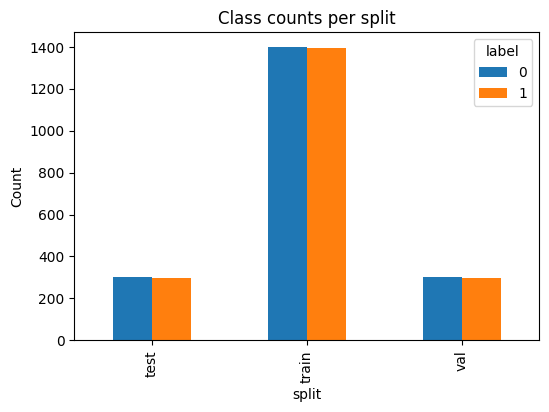

Parent overlaps (should be empty sets):
train ∩ val : [] 
train ∩ test: [] 
val ∩ test  : [] 


In [13]:


# Class distribution per split
ct = split.groupby(["split","label"]).size().unstack(fill_value=0)
ax = ct.plot(kind='bar', figsize=(6,4))
ax.set_title('Class counts per split'); ax.set_ylabel('Count')
fig = ax.get_figure(); fig.savefig(OUT_FIGS/"split_class_counts.png", bbox_inches='tight', dpi=150)
plt.show()

# Parent overlap check
parents = { s: set(split.loc[split['split']==s, 'parent']) for s in ['train','val','test'] }
overlap_tv = parents['train'] & parents['val']
overlap_tt = parents['train'] & parents['test']
overlap_vt = parents['val'] & parents['test']
print('Parent overlaps (should be empty sets):')
print('train ∩ val :', sorted(list(overlap_tv))[:20], '...' if len(overlap_tv)>20 else '')
print('train ∩ test:', sorted(list(overlap_tt))[:20], '...' if len(overlap_tt)>20 else '')
print('val ∩ test  :', sorted(list(overlap_vt))[:20], '...' if len(overlap_vt)>20 else '')


## TILING PARAMETERS (documented for overlay & metadata)


In [8]:

TILE_SIZE = 384
TILE_STRIDE = 256
MAX_TILES_PER_IMAGE = 32
VAR_KEEP_PCT = 0.70
APPLY_WHITENING = True
WH_ALPHA, WH_SIGMA = 0.1, 1.5


## TILING FUNCTION (splits-aware)

In [9]:


# Tiles each original TIFF into PNG tiles under OUT_TILES_ROOT/{split}/{class}/{parent}/tile_x{col}_y{row}.png
# Keeps only top VAR_KEEP_PCT by variance and caps MAX_TILES_PER_IMAGE; optional whitening.
import numpy as np
import math

def _to_rgb(np_img):
    if np_img.ndim==2:  # grayscale
        np_img = np.repeat(np_img[...,None], 3, axis=2)
    elif np_img.shape[2]==4:  # RGBA -> RGB
        np_img = np_img[...,:3]
    return np_img

def _whiten(img_f32, alpha=0.1, sigma=1.5):
    try:
        import cv2
        blurred = cv2.GaussianBlur(img_f32, (0,0), sigmaX=sigma, sigmaY=sigma)
        sharp = img_f32 + alpha*(img_f32 - blurred)
        return np.clip(sharp, 0, 1)
    except Exception:
        # fallback: simple high-boost with box blur
        from scipy.ndimage import gaussian_filter
        blurred = gaussian_filter(img_f32, sigma=sigma)
        sharp = img_f32 + alpha*(img_f32 - blurred)
        return np.clip(sharp, 0, 1)

def tile_split(split_df, out_root):
    out_root = Path(out_root)
    meta_files = {s: open(out_root/f"{s}_tiles_metadata.jsonl", "w") for s in ["train","val","test"]}
    kept_counter = 0
    for _, row in split_df.iterrows():
        img_path = Path(row["path"]); label = int(row["label"]); sp = row["split"]; parent = row["parent"]
        cls = "haze" if label==1 else "nonhaze"
        # read image
        im = Image.open(img_path)
        im = im.convert("RGB")  # force RGB
        W, H = im.size
        np_img = np.array(im).astype(np.float32) / 255.0  # [H,W,3]
        # tiling
        tiles = []
        for y in range(0, H - TILE_SIZE + 1, TILE_STRIDE):
            for x in range(0, W - TILE_SIZE + 1, TILE_STRIDE):
                tile = np_img[y:y+TILE_SIZE, x:x+TILE_SIZE, :]
                var = float(tile.var())
                tiles.append((var, x, y, tile))
        if not tiles:
            continue
        # keep top by variance
        tiles.sort(key=lambda t: t[0], reverse=True)
        k = max(1, int(math.ceil(len(tiles) * VAR_KEEP_PCT)))
        tiles = tiles[:k]
        # cap
        tiles = tiles[:MAX_TILES_PER_IMAGE]
        # write tiles
        out_dir = out_root / sp / cls / parent
        out_dir.mkdir(parents=True, exist_ok=True)
        for var, x, y, tile in tiles:
            if APPLY_WHITENING:
                tile = _whiten(tile, alpha=WH_ALPHA, sigma=WH_SIGMA)
            tile8 = (tile*255).astype(np.uint8)
            outp = out_dir / f"tile_x{x}_y{y}.png"
            Image.fromarray(tile8).save(outp)
            meta = {"split": sp, "class": cls, "label": label, "parent": parent,
                    "source_path": str(img_path), "tile_path": str(outp),
                    "x": x, "y": y, "tile_size": TILE_SIZE, "stride": TILE_STRIDE, "variance": var}
            meta_files[sp].write(json.dumps(meta) + "\n")
            kept_counter += 1
    for f in meta_files.values():
        f.close()
    print(f"Tiling complete. Kept tiles total: {kept_counter}. Metadata jsonl written per split under {out_root}.")


## writes the PNGs + JSONL metadata (Run once)

In [14]:

# split = grouped_stratified_split(df, ratios=SPLIT_RATIOS, seed=SEED)

tile_split(split, OUT_TILES_ROOT)  # this actually writes the PNGs + JSONL metadata


NameError: name 'tile_split' is not defined

## TILE INTENSITY CHECKS (mean & variance)

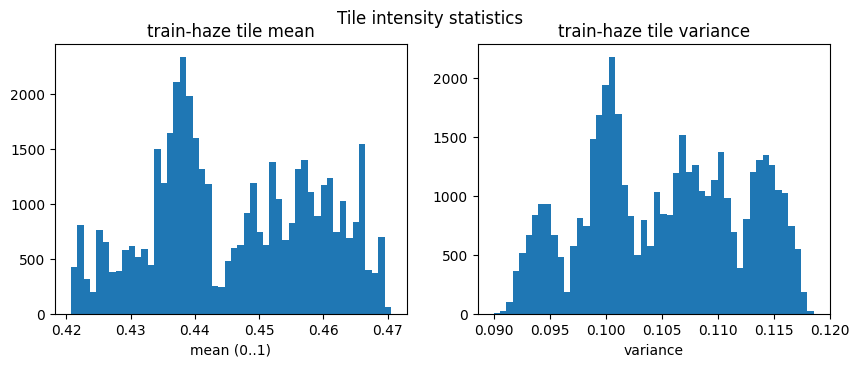

KeyboardInterrupt: 

In [49]:


import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def tile_stats(tiles_root, split, cls):
    means, vars_ = [], []
    for p in Path(tiles_root/split/cls).rglob("*.png"):
        im = np.array(Image.open(p)).astype(np.float32)/255.0
        means.append(im.mean()); vars_.append(im.var())
    return np.array(means), np.array(vars_)

for s in ["train","val","test"]:
    for cls in ["haze","nonhaze"]:
        base = OUT_TILES_ROOT/s/cls
        if not base.exists(): 
            continue
        m, v = tile_stats(OUT_TILES_ROOT, s, cls)
        if len(m)==0: 
            continue
        fig, ax = plt.subplots(1,2, figsize=(10,3.5))
        ax[0].hist(m, bins=50); ax[0].set_title(f"{s}-{cls} tile mean"); ax[0].set_xlabel("mean (0..1)")
        ax[1].hist(v, bins=50); ax[1].set_title(f"{s}-{cls} tile variance"); ax[1].set_xlabel("variance")
        fig.suptitle("Tile intensity statistics")
        fig.savefig(OUT_FIGS/f"{s}_{cls}_tile_intensity_stats.png", bbox_inches='tight', dpi=150)
        plt.show()


## DATASET WRAPPER (expects pre-extracted tiles) 

In [10]:


from PIL import Image

class TileDataset(Dataset):
    """Assumes tiles under OUT_TILES_ROOT/split/class/parent/tile_*.png (RGB)."""
    def __init__(self, tiles_root, split):
        self.tiles_root = Path(tiles_root); self.split = split
        self.items = []
        for cls, label in [("haze",1), ("nonhaze",0)]:
            base = (self.tiles_root / split / cls)
            if base.exists():
                for p in base.rglob("*.png"):
                    self.items.append((p, label))
        assert len(self.items)>0, f"No tiles found under {self.tiles_root}/{split}"
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        p, y = self.items[i]
        im = Image.open(p).convert("RGB")
        im = np.array(im).astype(np.float32)/255.0
        im = torch.from_numpy(im).permute(2,0,1)  # C,H,W
        return im, torch.tensor(y).long(), str(p)



## TILE COUNT PER PARENT PER SPLIT

In [11]:

import pandas as pd
counts = []
for s in ['train','val','test']:
    for cls in ['haze','nonhaze']:
        base = (OUT_TILES_ROOT/s/cls)
        if base.exists():
            for parent in base.iterdir():
                if parent.is_dir():
                    ntiles = sum(1 for _ in parent.glob('*.png'))
                    counts.append({"split":s, "class":cls, "parent":parent.name, "tiles":ntiles})

counts_df = pd.DataFrame(counts)
if not counts_df.empty:
    pivot = counts_df.pivot_table(index=['split','parent'], values='tiles', aggfunc='sum')
    display(pivot.sort_values(by='tiles', ascending=False).head())
else:
    print('No tile folders found to count.')


tiles
split parent            
val   noheat_1999     32
test  0cm_0020        32
      0cm_0035        32
      0cm_0042        32
      0cm_0049        32


## NORMALIZATION (ImageNet or dataset stats)

In [12]:

#  NORMALIZATION CHOICE 
NORM = "imagenet"  # set to 'dataset' to compute stats from training tiles


In [13]:

def compute_dataset_mean_std(tile_root, split="train", max_samples=2000, seed=42):
    rng = np.random.RandomState(seed)
    ds = TileDataset(tile_root, split)
    idxs = rng.choice(len(ds), size=min(max_samples, len(ds)), replace=False)
    sums = torch.zeros(3); sqs = torch.zeros(3); n = 0
    for i in idxs:
        im, y, p = ds[i]  # [3,H,W] in 0..1
        sums += im.view(3,-1).mean(dim=1)
        sqs  += (im.view(3,-1)**2).mean(dim=1)
        n += 1
    mean = (sums / n).tolist()
    std  = (sqs / n - (sums/n)**2).sqrt().tolist()
    return mean, std

if NORM == "dataset":
    MEAN, STD = compute_dataset_mean_std(OUT_TILES_ROOT, "train", max_samples=2000, seed=SEED)
else:
    MEAN, STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

print("Normalization -> MEAN:", MEAN, "STD:", STD)


Normalization -> MEAN: [0.485, 0.456, 0.406] STD: [0.229, 0.224, 0.225]


## DATALOADERS PARAMETERS 

In [14]:


BATCH_SIZE = 32
NUM_WORKERS = 4
AUG_HFLIP = True


## TRANSFORMS & DATALOADERS 

In [15]:



train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5) if AUG_HFLIP else transforms.Lambda(lambda x:x),
    transforms.Normalize(MEAN, STD),
])

eval_tfms = transforms.Compose([
    transforms.Normalize(MEAN, STD),
])


class TileDatasetTfm(TileDataset):
    def __init__(self, tiles_root, split, tfm):
        super().__init__(tiles_root, split); self.tfm = tfm
    def __getitem__(self, i):
        im3, y, p = super().__getitem__(i)  # im3 in 0..1
        im3 = self.tfm(im3)
        return im3, y, p

train_ds = TileDatasetTfm(OUT_TILES_ROOT, "train", train_tfms)
val_ds   = TileDatasetTfm(OUT_TILES_ROOT, "val",   eval_tfms)
test_ds  = TileDatasetTfm(OUT_TILES_ROOT, "test",  eval_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)



In [16]:
def prevalence(ds):
    import collections
    c = collections.Counter(int(y.item()) for _, y, _ in ds)
    n = sum(c.values())
    return {k: f"{v} ({v/n:.1%})" for k,v in sorted(c.items())}

print("Class prevalence:", {"train": prevalence(train_ds), "val": prevalence(val_ds), "test": prevalence(test_ds)})


Class prevalence: {'train': {0: '44800 (50.1%)', 1: '44576 (49.9%)'}, 'val': {0: '9600 (50.2%)', 1: '9536 (49.8%)'}, 'test': {0: '9600 (50.1%)', 1: '9569 (49.9%)'}}


## MONTAGE: train vs val 

In [ ]:


from torchvision.utils import make_grid
def denorm(x, mean, std):
    x = x.clone()
    for c in range(3): x[:,c] = x[:,c]*std[c] + mean[c]
    return x.clamp(0,1)

import torch
import random
samples = 16
idxs_tr = random.sample(range(len(train_ds)), min(samples, len(train_ds)))
imgs_tr = torch.stack([train_ds[i][0] for i in idxs_tr])
imgs_tr = denorm(imgs_tr, MEAN, STD)
grid_tr = make_grid(imgs_tr, nrow=4)
plt.figure(figsize=(8,8)); plt.imshow(grid_tr.permute(1,2,0).numpy()); plt.axis('off'); plt.title('Train (augmented) samples')
plt.savefig(OUT_FIGS/"montage_train.png", bbox_inches='tight', dpi=150); plt.show()

idxs_va = random.sample(range(len(val_ds)), min(samples, len(val_ds)))
imgs_va = torch.stack([val_ds[i][0] for i in idxs_va])
imgs_va = denorm(imgs_va, MEAN, STD)
grid_va = make_grid(imgs_va, nrow=4)
plt.figure(figsize=(8,8)); plt.imshow(grid_va.permute(1,2,0).numpy()); plt.axis('off'); plt.title('Val (clean) samples')
plt.savefig(OUT_FIGS/"montage_val.png", bbox_inches='tight', dpi=150); plt.show()


## INTENSITY HISTOGRAMS (post-normalization proxy)

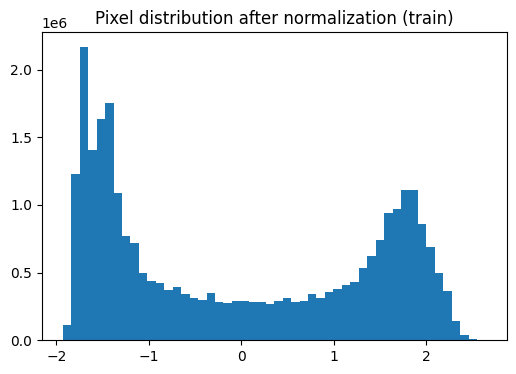

In [29]:


def gather_pixels(ds, n=64):
    rng = np.random.RandomState(42)
    idxs = rng.choice(len(ds), size=min(n, len(ds)), replace=False)
    vals = [ds[i][0].cpu().numpy() for i in idxs]
    arr = np.concatenate(vals, axis=1)  # [C, H*n, W]
    return arr

arr_tr = gather_pixels(train_ds, n=64)
plt.figure(figsize=(6,4)); plt.hist(arr_tr.ravel(), bins=50); plt.title('Pixel distribution after normalization (train)')
plt.savefig(OUT_FIGS/"hist_postnorm_train.png", bbox_inches='tight', dpi=150); plt.show()


## PROXY INTENSITY HISTOGRAM BY CLASS (train)

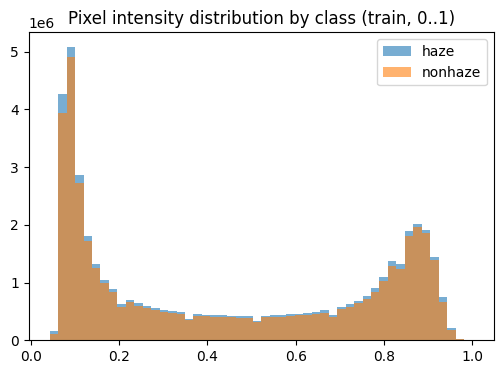

In [30]:


N = 200
base_ds = TileDataset(OUT_TILES_ROOT, 'train')
import random, numpy as np
vals_pos, vals_neg = [], []
idxs = random.sample(range(len(base_ds)), min(N, len(base_ds)))
for i in idxs:
    im, y, p = base_ds[i]  # im in 0..1
    (vals_pos if int(y)==1 else vals_neg).append(im.numpy().ravel())
if vals_pos and vals_neg:
    vp = np.concatenate(vals_pos); vn = np.concatenate(vals_neg)
    plt.figure(figsize=(6,4))
    plt.hist(vp, bins=50, alpha=0.6, label='haze')
    plt.hist(vn, bins=50, alpha=0.6, label='nonhaze')
    plt.legend(); plt.title('Pixel intensity distribution by class (train, 0..1)')
    plt.savefig(OUT_FIGS/"proxy_intensity_by_class.png", bbox_inches='tight', dpi=150); plt.show()
else:
    print('Not enough samples to draw class-wise intensity hist.')


## TRAINING PARAMETERS

In [16]:


EPOCHS = 3
LR = 3e-4
WEIGHT_DECAY = 1e-4
USE_POS_WEIGHT = True
SCHEDULER = "plateau"   # 'plateau' | 'onecycle' | 'cosine'
EARLY_STOP_PATIENCE = 5


## MODEL / LOSS / OPTIMIZER / SCHEDULER

In [20]:


model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 1)  # binary logits
model = model.cuda()

pos_weight = None
if USE_POS_WEIGHT:
    ys = [int(y.item()) for _, y, _ in train_ds]
    pos = sum(ys); neg = len(ys)-pos
    if pos > 0: pos_weight = torch.tensor([neg/pos], dtype=torch.float32).cuda()

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

if SCHEDULER=="plateau":
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)
elif SCHEDULER=="onecycle":
    steps_per_epoch = max(1, len(train_loader))
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=steps_per_epoch, epochs=EPOCHS)
elif SCHEDULER=="cosine":
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
else:
    scheduler = None

best_val_auc = -1; epochs_no_improve = 0
best_path = OUT_CKPTS / "best.pt"


## TRAINING LOOP (checkpoint best val AUC + early stopping) 

In [21]:


from sklearn.metrics import roc_auc_score

def run_epoch(loader, train=False):
    model.train(train)
    losses, ys, ps = [], [], []
    for x, y, _ in loader:
        x = x.cuda(non_blocking=True); y = y.cuda().float().view(-1,1)
        with torch.set_grad_enabled(train):
            logit = model(x); loss = criterion(logit, y)
        if train:
            optimizer.zero_grad(set_to_none=True); loss.backward(); optimizer.step()
        losses.append(loss.item()); ps.append(logit.detach().sigmoid().cpu()); ys.append(y.detach().cpu())
    y_true = torch.cat(ys).numpy().ravel(); y_prob = torch.cat(ps).numpy().ravel()
    auc_val = roc_auc_score(y_true, y_prob)
    return float(np.mean(losses)), float(auc_val), y_true, y_prob

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_auc, _, _ = run_epoch(train_loader, train=True)
    va_loss, va_auc, vy, vp = run_epoch(val_loader, train=False)

    # Step the scheduler
    if SCHEDULER=="plateau":
        scheduler.step(va_auc)
    elif SCHEDULER in ("onecycle","cosine"):
        scheduler.step()

    # Print metrics and LR
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch:02d} | lr {current_lr:.6f} | "
          f"train loss {tr_loss:.4f}, AUC {tr_auc:.3f} | "
          f"val loss {va_loss:.4f}, AUC {va_auc:.3f}")

    # Save best checkpoint
    if va_auc > best_val_auc + 1e-4:
        best_val_auc = va_auc; epochs_no_improve = 0
        torch.save({"model": model.state_dict(), "auc": best_val_auc}, best_path)
        print(f"saved best to {best_path} (val AUC={best_val_auc:.3f})")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLY_STOP_PATIENCE:
            print("  Early stopping triggered."); break

ckpt = torch.load(best_path, map_location="cuda"); model.load_state_dict(ckpt["model"])
print(f"Loaded best checkpoint (val AUC={ckpt['auc']:.3f})")


Epoch 01 | lr 0.000300 | train loss 0.0340, AUC 0.999 | val loss 0.0097, AUC 1.000
saved best to outputs/checkpoints/best.pt (val AUC=1.000)
Epoch 02 | lr 0.000300 | train loss 0.0172, AUC 1.000 | val loss 0.0086, AUC 1.000
Epoch 03 | lr 0.000300 | train loss 0.0146, AUC 1.000 | val loss 0.0040, AUC 1.000
Loaded best checkpoint (val AUC=1.000)


## Baseline Comparisons

In [105]:
from sklearn.metrics import roc_auc_score

def stats_scores(loader):
    ys, vari, meanv = [], [], []
    for x,y,_ in loader:
        xx = x.clone()
        for c in range(3): xx[:,c] = xx[:,c]*STD[c] + MEAN[c]  # de-normalize to 0..1
        vari.append(xx.var(dim=(1,2,3)).cpu().numpy())
        meanv.append(xx.mean(dim=(1,2,3)).cpu().numpy())
        ys.append(y.numpy())
    return np.concatenate(ys), np.concatenate(vari), np.concatenate(meanv)

vy, vv, mv = stats_scores(val_loader)
print("AUC(var): ", float(roc_auc_score(vy, vv)))
print("AUC(mean):", float(roc_auc_score(vy, mv)))


AUC(var):  0.48517908015240496
AUC(mean): 0.48688921695854304


In [106]:
import torch.nn.functional as F
def sobel_energy_scores(loader):
    ys, es = [], []
    kx = torch.tensor([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=torch.float32).view(1,1,3,3).to(next(model.parameters()).device)
    ky = torch.tensor([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=torch.float32).view(1,1,3,3).to(next(model.parameters()).device)
    for x,y,_ in loader:
        x = x.to(next(model.parameters()).device).clone()
        for c in range(3): x[:,c] = x[:,c]*STD[c] + MEAN[c]
        x = x.clamp(0,1).mean(1, keepdim=True)  # grayscale
        gx = F.conv2d(x, kx, padding=1); gy = F.conv2d(x, ky, padding=1)
        e = (gx**2 + gy**2).mean(dim=(1,2,3)).detach().cpu().numpy()
        es.append(e); ys.append(y.numpy())
    return np.concatenate(ys), np.concatenate(es)

ys, es = sobel_energy_scores(val_loader)
print("AUC(Sobel energy):", float(roc_auc_score(ys, es)))


AUC(Sobel energy): 0.4839311337737696


In [107]:
# FFT high/low power ratio baseline (fixed labels/shapes) 
import numpy as np
import torch

def fft_ratio_scores(loader):
    ys, rs = [], []
    dev = next(model.parameters()).device
    for x, y, _ in loader:
        # y: [B] labels
        y_np = y.detach().cpu().numpy()
        # de-normalize to 0..1 and grayscale
        xx = x.to(dev).clone()
        for c in range(3):
            xx[:, c] = xx[:, c] * STD[c] + MEAN[c]
        xx = xx.clamp(0, 1).mean(1).cpu().numpy()  # [B,H,W]
        # per-image FFT ratio
        for i in range(xx.shape[0]):
            im = xx[i]
            Fim = np.fft.fftshift(np.abs(np.fft.fft2(im)))
            H, W = Fim.shape
            cy, cx = H // 2, W // 2
            rr = min(cy, cx)
            r_mid = int(rr * 0.35)
            low = Fim[cy - r_mid:cy + r_mid, cx - r_mid:cx + r_mid].mean()
            # mean over the complement region
            area_low = (2 * r_mid) * (2 * r_mid)
            mean_all = Fim.mean()
            mean_high = (mean_all * Fim.size - low * area_low) / (Fim.size - area_low + 1e-8)
            rs.append(float(mean_high / (low + 1e-8)))
            ys.append(int(y_np[i]))
    y = np.array(ys, dtype=np.int32)
    r = np.array(rs, dtype=np.float32)
    return y, r

from sklearn.metrics import roc_auc_score
yf, rf = fft_ratio_scores(val_loader)
print("Shapes:", yf.shape, rf.shape)
print("AUC(FFT high/low):", float(roc_auc_score(yf, rf)))



Shapes: (19136,) (19136,)
AUC(FFT high/low): 0.4917709152597175


## Perceptual hash (pHash) and cross-split near-duplicate check

In [108]:

import numpy as np
from PIL import Image
from pathlib import Path

def phash_64(im: Image.Image) -> int:
    im = im.convert('L').resize((32, 32), Image.BILINEAR)
    a = np.array(im, dtype=np.float32)
    d = np.fft.fft2(a)
    d = np.real(np.fft.fftshift(d))
    # take 8x8 around center
    H, W = d.shape
    c = d[H//2-4:H//2+4, W//2-4:W//2+4]
    th = c.mean()
    bits = (c > th).astype(np.uint8).flatten()
    h = 0
    for b in bits: h = (h << 1) | int(b)
    return h

def hamming(a: int, b: int) -> int:
    x = a ^ b
    # popcount
    cnt = 0
    while x:
        x &= x - 1
        cnt += 1
    return cnt

def collect_paths(loader, limit=None):
    ds = loader.dataset
    paths = []
    for i in range(len(ds)):
        p = (ds.samples[i][0] if hasattr(ds, 'samples')
             else ds.items[i][0] if hasattr(ds, 'items')
             else ds.files[i])
        paths.append(Path(p))
        if limit and len(paths) >= limit:
            break
    return paths

train_paths = collect_paths(train_loader, limit=5000)  # limit for speed; increase if needed
val_paths   = collect_paths(val_loader,   limit=5000)

def phash_map(paths):
    m = {}
    for p in paths:
        try:
            h = phash_64(Image.open(p))
            m.setdefault(h, []).append(p)
        except Exception:
            continue
    return m

train_hashes = phash_map(train_paths)
val_hashes   = phash_map(val_paths)

# check approximate matches via small Hamming distance
val_hash_list = list(val_hashes.keys())
near_dupes = []
for ht, train_files in train_hashes.items():
    for hv in val_hash_list:
        if hamming(ht, hv) <= 5:
            for tf in train_files:
                for vf in val_hashes[hv]:
                    near_dupes.append((tf, vf))
                    if len(near_dupes) >= 10:
                        break
                if len(near_dupes) >= 10:
                    break
    if len(near_dupes) >= 10:
        break

print("Near-duplicate train↔val pairs (≤5 bit Hamming):", len(near_dupes))
for a, b in near_dupes[:5]:
    print("  TRAIN:", a)
    print("  VAL  :", b)


Near-duplicate train↔val pairs (≤5 bit Hamming): 10
  TRAIN: outputs_tiles/train/haze/100cm_0124/tile_x1792_y1024.png
  VAL  : outputs_tiles/val/haze/20cm_0138/tile_x1792_y1024.png
  TRAIN: outputs_tiles/train/haze/100cm_0124/tile_x1792_y1024.png
  VAL  : outputs_tiles/val/haze/20cm_0138/tile_x768_y1536.png
  TRAIN: outputs_tiles/train/haze/100cm_0124/tile_x1792_y1024.png
  VAL  : outputs_tiles/val/haze/20cm_0138/tile_x256_y1280.png
  TRAIN: outputs_tiles/train/haze/100cm_0124/tile_x1792_y1024.png
  VAL  : outputs_tiles/val/haze/20cm_0138/tile_x256_y768.png
  TRAIN: outputs_tiles/train/haze/100cm_0124/tile_x1792_y1024.png
  VAL  : outputs_tiles/val/haze/20cm_0138/tile_x1024_y1536.png


## Per-parent probability summaries on VAL

In [44]:

from collections import defaultdict
from pathlib import Path
import numpy as np
import torch

dev = next(model.parameters()).device
model.eval()

parent_probs = defaultdict(list)
parent_labels = {}

with torch.no_grad():
    for batch in val_loader:
        # batch could be (x, y, paths) or (x, y, meta)
        if len(batch) < 3:
            raise RuntimeError("Expected val_loader to yield (x, y, paths/meta).")
        x, y, paths = batch
        x = x.to(dev)
        probs = model(x).sigmoid().squeeze(1).cpu().numpy()
        y_np = y.detach().cpu().numpy()

        # try to coerce 'paths' into a sequence of strings
        # if your third element is a dict or list of dicts, adjust the line below
        if isinstance(paths, (list, tuple)):
            path_list = [str(p) for p in paths]
        else:
            # e.g., torch tensor of strings is rare; handle common fallbacks
            try:
                path_list = [str(p) for p in paths]
            except Exception:
                raise RuntimeError("Cannot parse paths from the third batch element; print(batch[2]) to inspect.")

        for p_str, yi, pi in zip(path_list, y_np, probs):
            pid = Path(p_str).parent.name  # e.g., '0cm_0020'
            parent_probs[pid].append(float(pi))
            # if parents are pure-class, this will be consistent; keep first seen
            if pid not in parent_labels:
                parent_labels[pid] = int(yi)

# Summaries
rows = []
for pid, ps in parent_probs.items():
    rows.append((pid, parent_labels.get(pid, -1), float(np.mean(ps)), float(np.std(ps)), len(ps)))
rows = sorted(rows, key=lambda t: t[2], reverse=True)

print("Top 5 'haze-looking' parents on VAL (by mean prob):")
for r in rows[:5]:
    print(r)  # (parent_id, label, mean_p, std_p, n_tiles)

print("Top 5 'nonhaze-looking' parents on VAL (by mean prob ascending):")
for r in rows[-5:]:
    print(r)



Top 5 'haze-looking' parents on VAL (by mean prob):
('60cm_0059', 1, 0.9999121055006981, 0.00010690100076661866, 32)
('20cm_0035', 1, 0.9999023973941803, 0.00013184813008567384, 32)
('60cm_0154', 1, 0.9998959451913834, 0.00012326406717361958, 32)
('80cm_0028', 1, 0.9998942315578461, 0.0001409413710336794, 32)
('100cm_0067', 1, 0.9998940154910088, 0.00012377228371933253, 32)
Top 5 'nonhaze-looking' parents on VAL (by mean prob ascending):
('noheat_0283', 0, 0.00016080272519669592, 0.00025567909874755357, 32)
('noheat_1130', 0, 0.0001593866498010854, 0.0002657074497308269, 32)
('noheat_0564', 0, 0.00014900497694458892, 0.00021415163199329243, 32)
('noheat_0562', 0, 0.0001489973556454416, 0.00020714632287848392, 32)
('noheat_0241', 0, 0.0001478664184795253, 0.00023050740196356185, 32)


In [45]:
#  Guard: model params must NOT change across val pass 
import hashlib
import torch

def sha_model_params(model):
    h = hashlib.sha256()
    for p in model.parameters():
        h.update(p.detach().cpu().numpy().tobytes())
    return h.hexdigest()

model.eval()
sig_before = sha_model_params(model)
with torch.no_grad():
    for x, y, _ in val_loader:
        _ = model(x.to(next(model.parameters()).device)).sigmoid()
sig_after = sha_model_params(model)

print("Params changed during VAL? ->", sig_before != sig_after)


Params changed during VAL? -> False


## Parent-level AUC Checks

In [47]:
# Parent-level metrics on VAL
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import numpy as np
from collections import defaultdict
from pathlib import Path
import torch

dev = next(model.parameters()).device
model.eval()
parent_probs, parent_labels = defaultdict(list), {}

with torch.no_grad():
    for x, y, paths in val_loader:
        x = x.to(dev)
        p = model(x).sigmoid().squeeze(1).cpu().numpy()
        y = y.cpu().numpy()
        if not isinstance(paths, (list, tuple)):
            paths = [str(p) for p in paths]
        for pi, yi, ps in zip(p, y, paths):
            pid = Path(ps).parent.name
            parent_probs[pid].append(float(pi))
            if pid not in parent_labels:
                parent_labels[pid] = int(yi)

pids = sorted(parent_probs.keys())
y_parent = np.array([parent_labels[pid] for pid in pids])
p_parent = np.array([np.mean(parent_probs[pid]) for pid in pids])

thr_parent = 0.5  # or choose on VAL parents via Youden’s J, then *report test on parents*
auc_parent = roc_auc_score(y_parent, p_parent)
yhat_parent = (p_parent >= thr_parent).astype(int)
acc_parent = accuracy_score(y_parent, yhat_parent)
f1_parent  = f1_score(y_parent, yhat_parent)

print(f"VAL parent-level — AUC {auc_parent:.4f}, Acc {acc_parent:.4f}, F1 {f1_parent:.4f} (thr={thr_parent})")


VAL parent-level — AUC 1.0000, Acc 1.0000, F1 1.0000 (thr=0.5)


In [48]:
# Cluster-robust CI at parent level (block bootstrap)
import numpy as np
from sklearn.metrics import roc_auc_score
rng = np.random.RandomState(42)
B = 1000
aucs = []
for _ in range(B):
    idx = rng.randint(0, len(pids), len(pids))  # resample parents with replacement
    aucs.append(roc_auc_score(y_parent[idx], p_parent[idx]))
lo, hi = np.percentile(aucs, [2.5, 97.5])
print(f"Parent-level AUC 95% CI: [{lo:.4f}, {hi:.4f}]")


Parent-level AUC 95% CI: [1.0000, 1.0000]


## Parent Overlap Checks

In [37]:
from pathlib import Path
def true_parent_id(path):
    p = Path(path)
    return p.parent.name  # the <PARENT> folder

def collect_true_parents(loader):
    ds = loader.dataset
    stems = set()
    for i in range(len(ds)):
        # adapt these accessors to your Dataset
        path = (ds.samples[i][0] if hasattr(ds, 'samples')
                else ds.items[i][0] if hasattr(ds, 'items')
                else ds.files[i])
        stems.add(true_parent_id(path))
    return stems

train_par = collect_true_parents(train_loader)
val_par   = collect_true_parents(val_loader)
overlap   = train_par & val_par
print("TRUE parent overlap (should be 0):", len(overlap))
print("Examples:", list(sorted(overlap))[:10])


TRUE parent overlap (should be 0): 0
Examples: []


## METRICS & PLOTS (with bootstrap CIs)

In [20]:


def youdens_j(y_true, y_prob):
    fpr, tpr, thr = roc_curve(y_true, y_prob); j = tpr - fpr; i = np.argmax(j); return thr[i]

def bootstrap_ci_auc(y_true, y_prob, kind="roc", n_boot=200, seed=42):
    rng = np.random.RandomState(seed); vals = []; n = len(y_true)
    for _ in range(n_boot):
        idx = rng.randint(0, n, n); yt = y_true[idx]; yp = y_prob[idx]
        if kind=="roc":
            fpr, tpr, _ = roc_curve(yt, yp); vals.append(auc(fpr, tpr))
        else:
            prec, rec, _ = precision_recall_curve(yt, yp); vals.append(auc(rec, prec))
    lo, hi = np.percentile(vals, [2.5, 97.5]); return lo, hi

def plot_confusion(y_true, y_prob, threshold, title, savepath=None):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks([0,1]); ax.set_yticks([0,1]); ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title(title)
    for (i,j),v in np.ndenumerate(cm): ax.text(j, i, str(v), ha='center', va='center')
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04); cbar.set_label('Count')
    if savepath: fig.savefig(savepath, bbox_inches='tight', dpi=150)
    plt.show()

def plot_roc_pr(y_true, y_prob, split, save_dir):
    fpr, tpr, _ = roc_curve(y_true, y_prob); roc_auc = auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(y_true, y_prob); pr_auc = auc(rec, prec)
    lo_roc, hi_roc = bootstrap_ci_auc(y_true, y_prob, kind='roc')
    lo_pr,  hi_pr  = bootstrap_ci_auc(y_true, y_prob, kind='pr')

    fig1, ax1 = plt.subplots(figsize=(5,4))
    ax1.plot(fpr, tpr, label=f'AUC={roc_auc:.3f} (95% CI {lo_roc:.3f}-{hi_roc:.3f})')
    ax1.plot([0,1],[0,1],'--'); ax1.set_xlabel('FPR'); ax1.set_ylabel('TPR'); ax1.set_title(f'{split} ROC'); ax1.legend()
    fig1.savefig(Path(save_dir)/f"{split}_roc.png", bbox_inches='tight', dpi=150); plt.show()

    fig2, ax2 = plt.subplots(figsize=(5,4))
    ax2.plot(rec, prec, label=f'AUC={pr_auc:.3f} (95% CI {lo_pr:.3f}-{hi_pr:.3f})')
    ax2.set_xlabel('Recall'); ax2.set_ylabel('Precision'); ax2.set_title(f'{split} PR'); ax2.legend()
    fig2.savefig(Path(save_dir)/f"{split}_pr.png", bbox_inches='tight', dpi=150); plt.show()

def plot_calibration(y_true, y_prob, split, save_dir):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')
    brier = brier_score_loss(y_true, y_prob)
    fig, ax = plt.subplots(figsize=(5,4))
    hm = ax.plot(prob_pred, prob_true, marker='o'); ax.plot([0,1],[0,1],'--')
    ax.set_xlabel('Predicted probability'); ax.set_ylabel('Observed fraction'); ax.set_title(f'{split} calibration (Brier={brier:.3f})')
    fig.savefig(Path(save_dir)/f"{split}_calibration.png", bbox_inches='tight', dpi=150); plt.show()

def threshold_sweep_marked(y_true, y_prob, thr, savepath=None):
    ts = np.linspace(0,1,101); sens, spec, prec = [], [], []
    for t in ts:
        yp = (y_prob>=t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yp, labels=[0,1]).ravel()
        sens.append(tp/(tp+fn+1e-9)); spec.append(tn/(tn+fp+1e-9)); prec.append(tp/(tp+fp+1e-9))
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(ts, sens, label='Sensitivity'); ax.plot(ts, spec, label='Specificity'); ax.plot(ts, prec, label='Precision')
    ax.axvline(thr, color='k', linestyle='--', label=f'Threshold={thr:.2f}')
    ax.set_xlabel('Threshold'); ax.set_ylabel('Score'); ax.set_title('Threshold sweep (with chosen threshold)'); ax.legend()
    if savepath: fig.savefig(savepath, bbox_inches='tight', dpi=150)
    plt.show()


## COLLECT PREDICTIONS & DIAGNOSTICS

Chosen threshold (Youden's J): 0.8824687


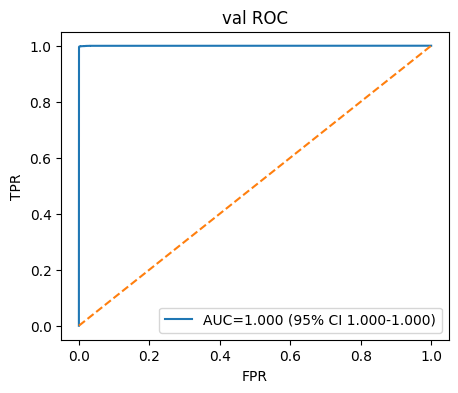

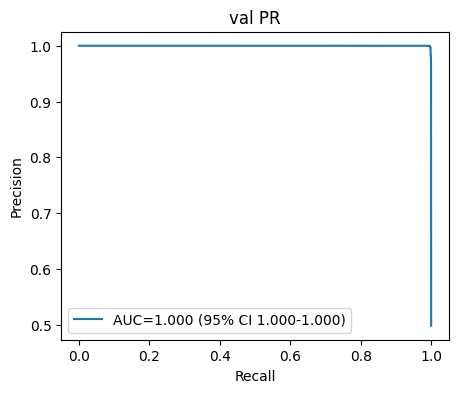

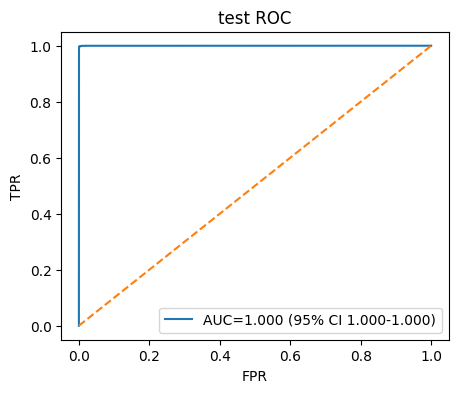

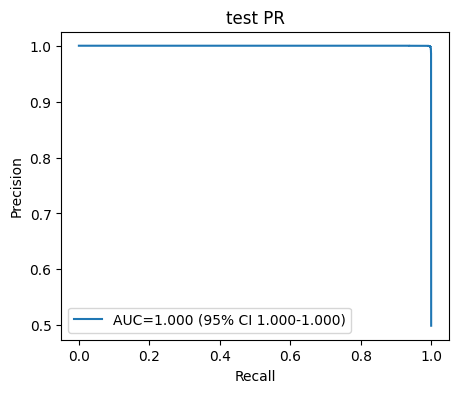

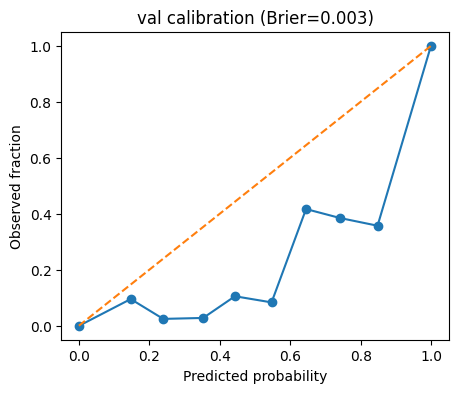

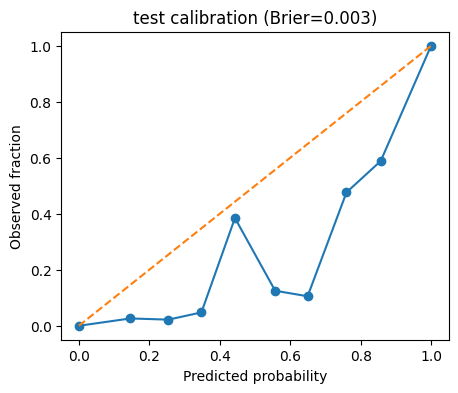

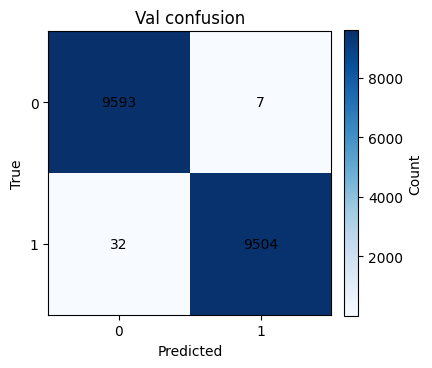

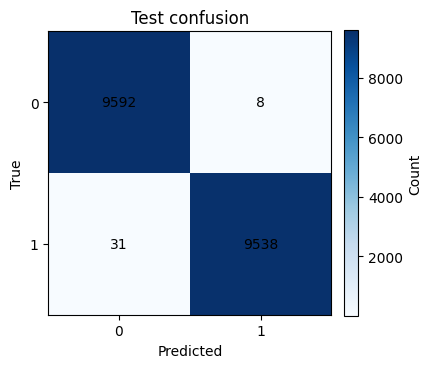

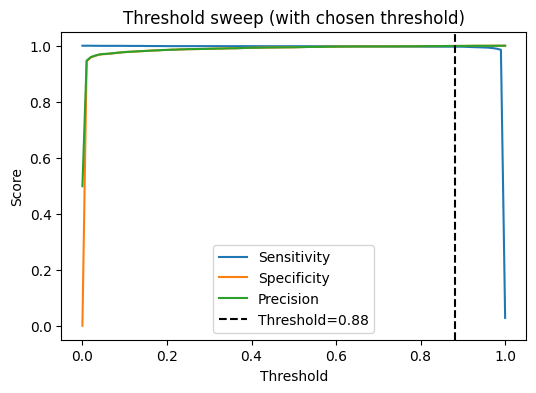

In [21]:


def collect(loader):
    ys, ps = [], []
    model.eval()
    with torch.no_grad():
        for x, y, _ in loader:
            x = x.cuda(); logit = model(x); prob = logit.sigmoid().cpu().numpy().ravel()
            ys.append(y.numpy().ravel()); ps.append(prob)
    return np.concatenate(ys), np.concatenate(ps)

vy, vp = collect(val_loader); ty, tp = collect(test_loader)
thr = youdens_j(vy, vp); print("Chosen threshold (Youden's J):", thr)

plot_roc_pr(vy, vp, "val", OUT_FIGS); plot_roc_pr(ty, tp, "test", OUT_FIGS)
plot_calibration(vy, vp, "val", OUT_FIGS); plot_calibration(ty, tp, "test", OUT_FIGS)
plot_confusion(vy, vp, thr, "Val confusion", savepath=OUT_FIGS/"val_confusion.png")
plot_confusion(ty, tp, thr, "Test confusion", savepath=OUT_FIGS/"test_confusion.png")
threshold_sweep_marked(vy, vp, thr, savepath=OUT_FIGS/"val_threshold_sweep_marked.png")


In [91]:
# --- Robust imports & fig saver ---
from pathlib import Path
from PIL import Image, ImageDraw  # some cells relied on earlier state

def savefig_tight(fig, path, dpi=150, top_pad=0.93, **kwargs):
    path = Path(path); path.parent.mkdir(parents=True, exist_ok=True)
    try:
        fig.tight_layout(rect=[0, 0, 1, top_pad])   # reserve top margin
    except Exception:
        pass
    fig.savefig(path, dpi=dpi, bbox_inches='tight', pad_inches=0.2, **kwargs)


## Reliability curve + ECE + Brier (TEST, 10 quantile bins)

In [92]:
import os, numpy as np, matplotlib.pyplot as plt

os.makedirs(OUT_FIGS, exist_ok=True)

def reliability_bins(y, p, n_bins=10, strategy='quantile'):
    y = np.asarray(y).astype(float)
    p = np.asarray(p).astype(float)
    assert y.ndim == 1 and p.ndim == 1 and y.shape[0] == p.shape[0], "Shapes must match (N,)."

    if strategy == 'quantile':
        # Quantile edges; guard against duplicate edges from ties
        raw_edges = np.quantile(p, np.linspace(0, 1, n_bins+1))
        edges = np.unique(np.r_[0.0, raw_edges, 1.0])
        # If too many duplicates collapsed, fall back to uniform
        if edges.size < 3:
            edges = np.linspace(0, 1, n_bins+1)
    else:
        edges = np.linspace(0, 1, n_bins+1)

    confs, accs, counts = [], [], []
    for i in range(len(edges)-1):
        lo, hi = edges[i], edges[i+1]
        # include rightmost edge in last bin
        mask = (p >= lo) & (p < hi) if i < len(edges)-2 else (p >= lo) & (p <= hi)
        if not mask.any():
            continue
        confs.append(p[mask].mean())
        accs.append(y[mask].mean())
        counts.append(int(mask.sum()))

    confs, accs, counts = map(np.array, (confs, accs, counts))
    # Expected Calibration Error (ECE)
    ece = np.sum(np.abs(accs - confs) * counts) / counts.sum()
    # Brier score
    brier = np.mean((p - y)**2)

    return {
        "conf": confs,      # mean predicted prob in bin
        "acc": accs,        # empirical accuracy in bin
        "count": counts,    # samples per bin
        "ece": float(ece),
        "brier": float(brier)
    }

# Compute on TEST arrays
res_test = reliability_bins(ty, tp, n_bins=10, strategy='quantile')
print(f"TEST: ECE={res_test['ece']:.3f}, Brier={res_test['brier']:.3f} (10 quantile bins)")

# Save a small CSV table (optional but handy)
import pandas as pd
df_test = pd.DataFrame({
    "bin": np.arange(1, res_test["conf"].size+1),
    "conf_mean": res_test["conf"],
    "acc_mean": res_test["acc"],
    "count": res_test["count"]
})
csv_path = os.path.join(OUT_FIGS, "reliability_test_bins.csv")
df_test.to_csv(csv_path, index=False)
print("Saved reliability table:", csv_path)

# Plot reliability (no fancy styling; clear labels/units)
fig, ax = plt.subplots(figsize=(4.2, 3.4))
ax.plot([0,1],[0,1], linestyle='--', linewidth=1)  # perfect calibration
ax.plot(res_test["conf"], res_test["acc"], marker='o')
for c,a,n in zip(res_test["conf"], res_test["acc"], res_test["count"]):
    ax.annotate(str(n), (c, a), textcoords="offset points", xytext=(3,3), fontsize=7)

ax.set_xlabel('Predicted probability')
ax.set_ylabel('Empirical accuracy')
ax.set_title('Reliability (test)')
ax.set_xlim(0,1); ax.set_ylim(0,1)
fig.tight_layout()
out_png = os.path.join(OUT_FIGS, "reliability_test.png")
fig.savefig(out_png, dpi=150, bbox_inches='tight')
plt.close(fig)
print("Saved reliability plot:", out_png)

# Thesis-ready one-liner:
print(f"[Thesis] Test calibration: Brier={res_test['brier']:.3f}, ECE={res_test['ece']:.3f} (10 quantile bins).")


TEST: ECE=0.004, Brier=0.003 (10 quantile bins)
Saved reliability table: outputs/figs/reliability_test_bins.csv
Saved reliability plot: outputs/figs/reliability_test.png
[Thesis] Test calibration: Brier=0.003, ECE=0.004 (10 quantile bins).


##  PERMUTATION AUC SANITY

Permutation AUC test: observed AUC=1.000, mean_perm=0.500, p≈0.0020


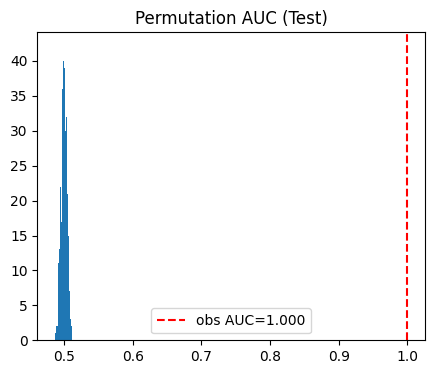

In [22]:


# Tests whether val AUC is meaningfully above chance by shuffling labels many times.
# If leakage existed, you'd often see anomalously high AUC even under permutations.
import numpy as np
rng = np.random.RandomState(42)
n_perm = 500
perm_aucs = []
for _ in range(n_perm):
    ty_perm = rng.permutation(ty)
    fpr, tpr, _ = roc_curve(ty_perm, tp)
    perm_aucs.append(auc(fpr, tpr))
perm_aucs = np.array(perm_aucs)
obs_fpr, obs_tpr, _ = roc_curve(ty, tp)
obs_auc = auc(obs_fpr, obs_tpr)
p_value = (np.sum(perm_aucs >= obs_auc)+1) / (n_perm+1)
print(f"Permutation AUC test: observed AUC={obs_auc:.3f}, mean_perm={perm_aucs.mean():.3f}, p≈{p_value:.4f}")
plt.figure(figsize=(5,4)); plt.hist(perm_aucs, bins=30)
plt.axvline(obs_auc, color='r', linestyle='--', label=f'obs AUC={obs_auc:.3f}')
plt.title('Permutation AUC (Test)'); plt.legend()
plt.savefig(OUT_FIGS/"val_perm_auc.png", bbox_inches='tight', dpi=150); plt.show()


## Held-out Accuracy & F1 with 95% CIs — add new cell after your ROC/PR metrics

In [94]:
# --- Accuracy & F1 with 95% CIs at the val-chosen threshold on TEST ---
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def bootstrap_metric_ci(y_true, y_prob, thr, metric_fn, n_boot=200, seed=42):
    rng = np.random.RandomState(seed); n = len(y_true); vals=[]
    y_hat = (y_prob >= thr).astype(int)
    for _ in range(n_boot):
        idx = rng.randint(0, n, n)
        vals.append(metric_fn(y_true[idx], y_hat[idx]))
    lo, hi = np.percentile(vals, [2.5, 97.5])
    return float(metric_fn(y_true, y_hat)), float(lo), float(hi)

acc, acc_lo, acc_hi = bootstrap_metric_ci(ty, tp, thr, accuracy_score)
f1,  f1_lo,  f1_hi  = bootstrap_metric_ci(ty, tp, thr, f1_score)

print(f"Test Accuracy @thr={thr:.3f}: {acc:.3f} (95% CI {acc_lo:.3f}-{acc_hi:.3f})")
print(f"Test F1       @thr={thr:.3f}: {f1:.3f} (95% CI {f1_lo:.3f}-{f1_hi:.3f})")


Test Accuracy @thr=0.882: 0.998 (95% CI 0.997-0.999)
Test F1       @thr=0.882: 0.998 (95% CI 0.997-0.999)


## Baselines: variance threshold + frozen-ResNet features + Logistic Regression 

In [95]:

from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression

def variance_scores(loader):
    ys, vs = [], []
    for x,y,_ in loader:
        xx = x.clone()
        for c in range(3):
            xx[:,c] = xx[:,c]*STD[c] + MEAN[c]   # de-normalize to 0..1
        v = xx.var(dim=(1,2,3)).cpu().numpy()
        ys.append(y.numpy()); vs.append(v)
    return np.concatenate(ys), np.concatenate(vs)

# Baseline 1: per-tile variance with val-tuned threshold
vy_b, vv_b = variance_scores(val_loader)
ty_b, tv_b = variance_scores(test_loader)
thr_var = youdens_j(vy_b, vv_b)
fpr, tpr, _ = roc_curve(ty_b, tv_b); auc_var = auc(fpr, tpr)
yhat_var = (tv_b >= thr_var).astype(int)
acc_var = accuracy_score(ty_b, yhat_var)
f1_var  = f1_score(ty_b, yhat_var)

# Baseline 2: frozen-ResNet features + Logistic Regression
model.eval()
feat_extractor = nn.Sequential(*list(model.children())[:-1]).eval()
def collect_feats_labels(loader):
    Fs, Ys = [], []
    with torch.no_grad():
        for x,y,_ in loader:
            x = x.to(next(model.parameters()).device)
            f = feat_extractor(x).squeeze(-1).squeeze(-1).cpu().numpy()
            Fs.append(f); Ys.append(y.numpy())
    return np.vstack(Fs), np.concatenate(Ys)

Fv, Yv = collect_feats_labels(val_loader)
Ft, Yt = collect_feats_labels(test_loader)
clf = LogisticRegression(max_iter=200, n_jobs=-1).fit(Fv, Yv)
probt = clf.predict_proba(Ft)[:,1]
fpr, tpr, _ = roc_curve(Yt, probt); auc_lr = auc(fpr, tpr)

# threshold for LR tuned on val
probv = clf.predict_proba(Fv)[:,1]
thr_lr = youdens_j(Yv, probv)
yhat_lr = (probt >= thr_lr).astype(int)
acc_lr = accuracy_score(Yt, yhat_lr)
f1_lr  = f1_score(Yt, yhat_lr)

print(f"AUC — Variance: {auc_var:.3f} | FrozenResNet+LR: {auc_lr:.3f}")
print(f"Acc — Variance: {acc_var:.3f} | FrozenResNet+LR: {acc_lr:.3f}")
print(f" F1 — Variance: {f1_var:.3f} | FrozenResNet+LR: {f1_lr:.3f}")


AUC — Variance: 0.481 | FrozenResNet+LR: 1.000
Acc — Variance: 0.503 | FrozenResNet+LR: 0.998
 F1 — Variance: 0.315 | FrozenResNet+LR: 0.998


In [96]:
import matplotlib.pyplot as plt
labels = ['Variance', 'Frozen+LR', 'Your model']
auc_vals = [auc_var, auc_lr, None]      # fill Your model AUC if you store it as auc_test
acc_vals = [acc_var, acc_lr, None]      # fill your acc@thr if stored
f1_vals  = [f1_var,  f1_lr,  None]      # fill your f1@thr if stored

# Safeguard if you don’t have your model’s scalars in vars yet:
auc_vals[2] = globals().get('auc_test', 0.0)
acc_vals[2] = globals().get('acc', 0.0)
f1_vals[2]  = globals().get('f1', 0.0)

for name, vals in [('AUC', auc_vals), ('Accuracy', acc_vals), ('F1', f1_vals)]:
    fig, ax = plt.subplots(figsize=(4.5,3.2))
    ax.bar(labels, vals)
    ax.set_title(name); ax.set_ylabel(name+' (unitless)')
    savefig_tight(fig, OUT_FIGS/f"baselines_{name.lower()}.png")
    plt.close(fig)


## Visual sampling audit (variance heatmap + kept vs dropped)

In [117]:
#  Sampling audit composite 
def variance_heatmap(sample_path):
    im = Image.open(sample_path).convert("RGB"); W,H = im.size
    heat = np.zeros((H, W), dtype=np.float32)
    np_img = np.array(im).astype(np.float32)/255.0
    for y in range(0, H - TILE_SIZE + 1, TILE_STRIDE):
        for x in range(0, W - TILE_SIZE + 1, TILE_STRIDE):
            tile = np_img[y:y+TILE_SIZE, x:x+TILE_SIZE, :]
            heat[y:y+TILE_SIZE, x:x+TILE_SIZE] = float(tile.var())
    heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)
    fig, ax = plt.subplots(figsize=(5,4))
    ax.imshow(heat, cmap='inferno'); ax.axis('off'); ax.set_title('Tile variance (unitless)')
    savefig_tight(fig, OUT_FIGS/"variance_heatmap.png"); plt.close(fig)

# REPLACE your kept_vs_dropped_overlay(...) with this (works for overlapping tiles)
from matplotlib.patches import Rectangle

def kept_vs_dropped_overlay(sample_path, tile_size=TILE_SIZE, stride=TILE_STRIDE, keep_pct=VAR_KEEP_PCT):
    im = Image.open(sample_path).convert("RGB")
    W, H = im.size
    img = np.array(im)

    # collect tiles + variance
    tiles = []
    for y in range(0, H - tile_size + 1, stride):
        for x in range(0, W - tile_size + 1, stride):
            t = img[y:y+tile_size, x:x+tile_size].astype(np.float32)/255.0
            tiles.append((float(t.var()), x, y))
    tiles.sort(key=lambda t: t[0], reverse=True)

    k = int(np.ceil(len(tiles) * keep_pct))
    kept = {(x, y) for _, x, y in tiles[:k]}

    # draw: filled rectangles (semi-transparent) so overlap is visible
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(img); ax.axis("off")

    fill_alpha = 0.25  # increase if you want stronger fill
    edge_w = 0.8
    for _, x, y in tiles:
        is_kept = (x, y) in kept
        face = (0.00, 0.80, 0.00, fill_alpha) if is_kept else (0.95, 0.15, 0.15, fill_alpha*0.8)
        edge = (0.00, 0.45, 0.00, 0.90) if is_kept else (0.75, 0.00, 0.00, 0.90)
        ax.add_patch(Rectangle((x, y), tile_size, tile_size,
                               linewidth=edge_w, edgecolor=edge, facecolor=face))

    # leftover bands (areas never tiled because stride doesn't land exactly at the edge)
    x_last = ((W - tile_size) // stride) * stride
    y_last = ((H - tile_size) // stride) * stride
    right  = W - (x_last + tile_size)
    bottom = H - (y_last + tile_size)
    if right > 0:
        ax.add_patch(Rectangle((x_last + tile_size, 0), right, H,
                               facecolor=(0.95, 0.15, 0.15, 0.35), edgecolor=None))
    if bottom > 0:
        ax.add_patch(Rectangle((0, y_last + tile_size), W, bottom,
                               facecolor=(0.15, 0.35, 0.95, 0.35), edgecolor=None))

    overlap = max(0, tile_size - stride)
    ax.set_title(f"Sliding tiles (T={tile_size}px, S={stride}px, overlap={overlap}px) — "
                 f"N={len(tiles)}, kept={k} ({100*k/len(tiles):.1f}%)")
    savefig_tight(fig, OUT_FIGS/"kept_vs_dropped.png"); plt.close(fig)


sample = next((RAW_ROOT/"haze").glob("*.tif*"), None) or next((RAW_ROOT/"nonhaze").glob("*.tif*"), None)
if sample:
    variance_heatmap(sample); kept_vs_dropped_overlay(sample)
    print("Saved:", OUT_FIGS/"variance_heatmap.png", "|", OUT_FIGS/"kept_vs_dropped.png")
else:
    print("No sample TIFF found under RAW_ROOT.")


Saved: outputs/figs/variance_heatmap.png | outputs/figs/kept_vs_dropped.png


## Grad-CAM (layer3 + SmoothGrad) with side-by-side viewer 

In [109]:
import torch.nn.functional as F


model.eval()
dev = next(model.parameters()).device

# helper to save without breaking if savefig_tight isn't defined
def _save(fig, path):
    try: savefig_tight(fig, path)
    except NameError:
        fig.tight_layout(); fig.savefig(path, dpi=150)

class SimpleGradCAM:
    def __init__(self, model, target_layer_module):
        self.model = model.eval()
        self.layer = target_layer_module
        self.activ = None; self.grads = None
        self.h1 = self.layer.register_forward_hook(self._hook_a)
        self.h2 = self.layer.register_full_backward_hook(self._hook_g)
    def _hook_a(self, m, i, o): self.activ = o
    def _hook_g(self, m, gi, go): self.grads = go[0]
    def __call__(self, x):
        self.model.zero_grad(set_to_none=True)
        out = self.model(x)                    # logits [B,1]
        out.sum().backward()
        w = self.grads.mean(dim=(2,3), keepdim=True)
        cam = torch.relu((w * self.activ).sum(dim=1, keepdim=True))
        cam = (cam - cam.amin((2,3), True)) / (cam.amax((2,3), True) - cam.amin((2,3), True) + 1e-8)
        return cam

# target a higher-res block (OS=16) for smoother "haze" look
cam_engine = SimpleGradCAM(model, model.layer3[-1])

def smooth_gradcam(cam_engine, x, n=8, noise_std=0.10):
    cams = []
    for _ in range(n):
        cams.append(cam_engine(x + torch.randn_like(x)*noise_std).detach())
    return torch.stack(cams, 0).mean(0)  # [B,1,hc,wc]

def denorm_01(x, mean=MEAN, std=STD):
    x = x.detach().cpu().clone()
    for c in range(3): x[c] = x[c]*std[c] + mean[c]
    return x.clamp(0,1)

def show_cam_triptych(x_norm_1, cam_small_1, outpath, cmap='magma', alpha=0.5, title=None):
    # upsample & light blur
    cam_up = F.interpolate(cam_small_1, size=x_norm_1.shape[-2:], mode='bilinear', align_corners=False)
    k, sigma = 15, 5.0
    g1 = torch.linspace(-(k//2), k//2, steps=k, device=x_norm_1.device)
    g = torch.exp(-0.5*(g1/sigma)**2); g = (g/g.sum())
    k2d = (g[:,None]*g[None,:]).unsqueeze(0).unsqueeze(0)
    cam_blur = F.conv2d(cam_up, k2d, padding=k//2)

    cam_img = cam_blur[0,0].clamp(0,1).detach().cpu().numpy()
    x = x_norm_1[0].detach().cpu().clone()
    for c in range(3): x[c] = x[c]*STD[c] + MEAN[c]
    img = (x.clamp(0,1).permute(1,2,0).numpy()*255).astype(np.uint8)

    fig, axs = plt.subplots(1,3, figsize=(9,3))
    if title: fig.suptitle(title, y=1.02, fontsize=10)
    axs[0].imshow(img); axs[0].axis('off'); axs[0].set_title('Tile')
    im1 = axs[1].imshow(cam_img, cmap=cmap, vmin=0, vmax=1)
    axs[1].axis('off'); axs[1].set_title('Grad-CAM')
    cbar = fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04); cbar.set_label('CAM intensity (0–1)')
    axs[2].imshow(img); axs[2].imshow(cam_img, cmap=cmap, alpha=alpha, vmin=0, vmax=1)
    axs[2].axis('off'); axs[2].set_title('Overlay')
    try: savefig_tight(fig, outpath)
    except NameError: fig.tight_layout(); fig.savefig(outpath, dpi=150)
    plt.close(fig)




## Misclassified CAM (AUTO-TAG FP/FN TILES BY FAILURE TYPE)

In [110]:
from pathlib import Path
import numpy as np

label_names = {0: "nonhaze", 1: "haze"}   # adjust if your 0/1 mapping differs

def save_cam_triptychs_batch(loader, out_dir, N=12, filt='all', cmap='magma', alpha=0.5, thr=None):
    """
    filt: 'all' | 'fp' | 'fn' | 'tp' | 'tn'
    """
    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    dev = next(model.parameters()).device
    model.eval()

    saved = 0
    for xb, yb, paths in loader:
        xb = xb.to(dev)
        with torch.no_grad():
            probs = model(xb).sigmoid().squeeze(1).cpu().numpy()
        y = yb.numpy()
        if not isinstance(paths, (list, tuple)):
            paths = [str(p) for p in paths]
        tthr = float(thr) if thr is not None else 0.5
        yhat = (probs >= tthr).astype(int)

        for i in range(len(y)):
            keep = True
            if   filt == 'fp': keep = (y[i]==0 and yhat[i]==1)
            elif filt == 'fn': keep = (y[i]==1 and yhat[i]==0)
            elif filt == 'tp': keep = (y[i]==1 and yhat[i]==1)
            elif filt == 'tn': keep = (y[i]==0 and yhat[i]==0)
            # else 'all' keeps everything
            if not keep: 
                continue

            # make SmoothGrad CAM for THIS tile
            cam_small = smooth_gradcam(cam_engine, xb[i:i+1], n=8, noise_std=0.10)

            title = f"GT={label_names[int(y[i])]} | p={probs[i]:.3f} | pred={label_names[int(yhat[i])]}"
            fname = f"{Path(paths[i]).parent.name}__{Path(paths[i]).stem}__GT-{label_names[int(y[i])]}__p{probs[i]:.3f}__pred-{label_names[int(yhat[i])]}.png"
            outpath = out_dir / fname
            show_cam_triptych(xb[i:i+1], cam_small, outpath, cmap=cmap, alpha=alpha, title=title)

            saved += 1
            if saved >= N:
                print(f"Saved {saved} panels to {out_dir}")
                return
    print(f"Saved {saved} panels to {out_dir}")


In [111]:
# AUTO-TAG FP/FN TILES BY FAILURE TYPE AND SAVE TRIPTYCHS 
import csv, os, math
from pathlib import Path

# --- image utilities on de-normalised RGB tile in [0,1] np.ndarray (H,W,3) ---
def _to_gray01(img01):  # simple luminance
    return (0.299*img01[...,0] + 0.587*img01[...,1] + 0.114*img01[...,2])

def _grad_mag_mean(gray):  # Sobel-ish via finite diff
    gx = np.abs(np.diff(gray, axis=1, prepend=gray[:, :1]))
    gy = np.abs(np.diff(gray, axis=0, prepend=gray[:1, :]))
    return float((gx+gy).mean())

def _sat_bright_frac(img01, thr=0.98):
    # fraction of near-saturated pixels in any channel
    return float((img01.max(axis=-1) >= thr).mean())

def _fft_peakiness(gray):
    # normalised "peakiness" of midband spectrum (periodic patterns -> higher)
    g = gray.astype(np.float32)
    g = g - g.mean()
    F = np.fft.fftshift(np.fft.fft2(g))
    P = np.abs(F)
    h, w = P.shape
    yy, xx = np.mgrid[-h//2:h//2, -w//2:w//2]
    rr = np.sqrt(xx**2 + yy**2)/max(h,w)
    mid = (rr >= 0.12) & (rr <= 0.45)   # mid-band annulus
    if not np.any(mid): return 0.0
    band = P[mid]
    if band.size < 10: return 0.0
    med = np.median(band); mx = np.max(band)
    return float((mx - med) / (mx + 1e-6))  # 0..1-ish

def _cam_border_ratio(cam01, r=0.15):
    h, w = cam01.shape
    b = int(min(h,w)*r)
    if b <= 0: return 0.0
    total = float(cam01.sum() + 1e-8)
    border = float(cam01[:b,:].sum() + cam01[-b:,:].sum() + cam01[:, :b].sum() + cam01[:, -b:].sum())
    return border / total

def _denorm_np(x1):
    # x1: torch tensor [1,3,H,W] normalised; returns np HxWx3 in [0,1]
    x = x1[0].detach().cpu().clone()
    for c in range(3): x[c] = x[c]*STD[c] + MEAN[c]
    return x.clamp(0,1).permute(1,2,0).numpy()

def _upsample_cam01(cam_small, HW):
    cam_up = F.interpolate(cam_small, size=HW, mode='bilinear', align_corners=False)
    cam = cam_up[0,0].clamp(0,1).detach().cpu().numpy()
    return cam

def diagnose_tile(img01, cam01):
    gray = _to_gray01(img01)
    scores = {
        "grad_mean": _grad_mag_mean(gray),
        "bright_frac": _sat_bright_frac(img01, thr=0.98),
        "fft_peak": _fft_peakiness(gray),
        "cam_border": _cam_border_ratio(cam01, r=0.15),
    }
    # --- simple, tunable rules (chosen conservative to avoid over-tagging) ---
    # Lower gradients -> lower texture. Bright_frac ~ specular/glare. fft_peak -> periodic.
    # cam_border high -> border-dominated attention.
    cat = "uncategorised"
    if scores["cam_border"] >= 0.55:
        cat = "border"
    elif scores["bright_frac"] >= 0.01:
        cat = "glare"
    elif scores["fft_peak"] >= 0.25:
        cat = "periodic"
    elif scores["grad_mean"] <= 0.02:
        cat = "low_texture"
    return cat, scores

def save_miscls_by_category(loader, out_dir, filt='fn', per_category=2, thr=None,
                            cmap='magma', alpha=0.5):
    """
    Saves up to `per_category` triptychs for each category from {low_texture, glare, periodic, border}.
    Only tiles matching `filt` (fn/fp/tp/tn) are considered.
    Also writes a CSV manifest with diagnostics.

    Example:
      save_miscls_by_category(test_loader, OUT_FIGS/'failures', filt='fn', per_category=2, thr=thr)
    """
    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    csv_path = out_dir / "manifest.csv"
    dev = next(model.parameters()).device
    model.eval()

    # keep counts per category
    want = {k: per_category for k in ["low_texture","glare","periodic","border"]}
    kept = {k: 0 for k in want}

    wrote_header = False
    with open(csv_path, "w", newline="") as fcsv:
        w = csv.writer(fcsv)
        for xb, yb, paths in loader:
            xb = xb.to(dev)
            with torch.no_grad():
                probs = model(xb).sigmoid().squeeze(1).cpu().numpy()
            y = yb.numpy()
            if not isinstance(paths, (list, tuple)): paths = [str(p) for p in paths]
            tthr = float(thr) if thr is not None else 0.5
            yhat = (probs >= tthr).astype(int)

            for i in range(len(y)):
                # filter by outcome
                keep = True
                if   filt == 'fp': keep = (y[i]==0 and yhat[i]==1)
                elif filt == 'fn': keep = (y[i]==1 and yhat[i]==0)
                elif filt == 'tp': keep = (y[i]==1 and yhat[i]==1)
                elif filt == 'tn': keep = (y[i]==0 and yhat[i]==0)
                if not keep: continue

                # build CAM for this tile
                cam_small = smooth_gradcam(cam_engine, xb[i:i+1], n=8, noise_std=0.10)
                cam01 = _upsample_cam01(cam_small, xb.shape[-2:])

                # de-normalised image
                img01 = _denorm_np(xb[i:i+1])

                # diagnose + assign category
                cat, scores = diagnose_tile(img01, cam01)
                if cat not in want or kept[cat] >= want[cat]:
                    continue  # either full or uncategorised

                # save triptych with category in filename
                title = f"GT={label_names[int(y[i])]} | p={probs[i]:.3f} | pred={label_names[int(yhat[i])]} | {cat}"
                base = f"{Path(paths[i]).parent.name}__{Path(paths[i]).stem}__{cat}__GT-{label_names[int(y[i])]}__p{probs[i]:.3f}__pred-{label_names[int(yhat[i])]}.png"
                outpath = out_dir / base
                show_cam_triptych(xb[i:i+1], cam_small, outpath, cmap=cmap, alpha=alpha, title=title)

                # write CSV row
                if not wrote_header:
                    w.writerow(["path","gt","pred","p","category","grad_mean","bright_frac","fft_peak","cam_border"])
                    wrote_header = True
                w.writerow([str(outpath), int(y[i]), int(yhat[i]), float(probs[i]), cat,
                            scores["grad_mean"], scores["bright_frac"], scores["fft_peak"], scores["cam_border"]])
                kept[cat] += 1

                # stop if all categories filled
                if all(kept[k] >= want[k] for k in want):
                    print("Saved per-category examples:", kept)
                    print("CSV:", csv_path)
                    return

    print("Saved per-category examples:", kept)
    print("CSV:", csv_path)


In [100]:
# 2 random VAL examples
save_cam_triptychs_batch(val_loader, OUT_FIGS/"cams_val_random", N=1, filt='all', cmap='magma', alpha=0.5, thr=thr)

# 2 false positives from TEST
save_cam_triptychs_batch(test_loader, OUT_FIGS/"cams_test_fp", N=1, filt='fp', cmap='magma', alpha=0.5, thr=thr)

# 2 false negatives from TEST
save_cam_triptychs_batch(test_loader, OUT_FIGS/"cams_test_fn", N=1, filt='fn', cmap='magma', alpha=0.5, thr=thr)


Saved 1 panels to outputs/figs/cams_val_random
Saved 1 panels to outputs/figs/cams_test_fp
Saved 1 panels to outputs/figs/cams_test_fn


In [101]:
save_cam_triptychs_batch(test_loader, OUT_FIGS/"cams_test_tp", N=1, filt='tp', cmap='magma', alpha=0.5, thr=thr)
save_cam_triptychs_batch(test_loader, OUT_FIGS/"cams_test_tn", N=1, filt='tn', cmap='magma', alpha=0.5, thr=thr)

Saved 1 panels to outputs/figs/cams_test_tp
Saved 1 panels to outputs/figs/cams_test_tn


In [102]:
# False negatives: 2 per category (adjust per_category as you like)
save_miscls_by_category(test_loader, OUT_FIGS/"failures_fn", filt='fn', per_category=2, thr=thr)

# False positives: 2 per category
save_miscls_by_category(test_loader, OUT_FIGS/"failures_fp", filt='fp', per_category=2, thr=thr)


Saved per-category examples: {'low_texture': 0, 'glare': 0, 'periodic': 1, 'border': 2}
CSV: outputs/figs/failures_fn/manifest.csv
Saved per-category examples: {'low_texture': 0, 'glare': 0, 'periodic': 0, 'border': 2}
CSV: outputs/figs/failures_fp/manifest.csv


## Whole-image saliency mosaic

Saved: outputs/figs/mosaic_triptych_with_labels.png


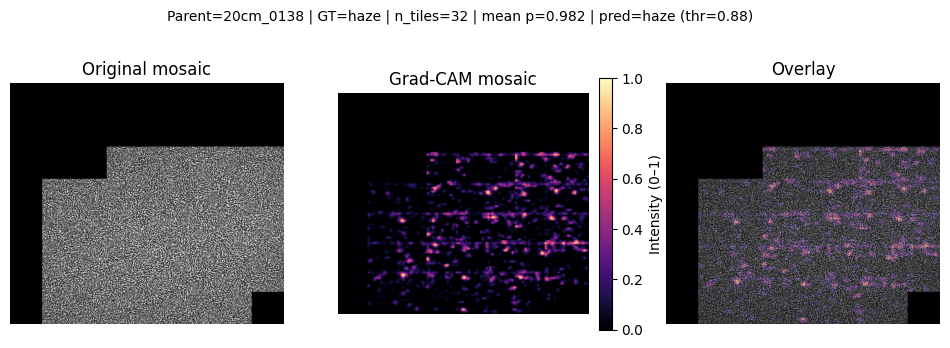

In [112]:
# Parent-level mosaics with labels

dev = next(model.parameters()).device

# helper: extract tile coords from filename
def _xy_from_name(name):
    m = re.search(r"tile_x(\d+)_y(\d+)\.png$", name)
    return (int(m.group(1)), int(m.group(2))) if m else None

# stitch RGB tiles (mean blend in overlaps)
def mosaic_rgb_for_parent(parent_dir, tile_size):
    acc = None; count = None
    tiles = sorted([p for p in Path(parent_dir).glob("*.png") if _xy_from_name(p.name)])
    if not tiles: return None
    maxY = max(_xy_from_name(p.name)[1] for p in tiles) + tile_size
    maxX = max(_xy_from_name(p.name)[0] for p in tiles) + tile_size
    acc   = np.zeros((maxY, maxX, 3), dtype=np.float32)
    count = np.zeros((maxY, maxX, 1), dtype=np.float32)
    for p in tiles:
        x, y = _xy_from_name(p.name)
        im = np.array(Image.open(p).convert("RGB"), dtype=np.float32)/255.0
        acc[y:y+tile_size, x:x+tile_size, :] += im
        count[y:y+tile_size, x:x+tile_size, :] += 1.0
    return acc / np.clip(count, 1.0, None)

# stitch CAM tiles (max blend in overlaps)
def mosaic_cam_for_parent(parent_dir, cam_fn, tile_size):
    tiles = sorted([p for p in Path(parent_dir).glob("*.png") if _xy_from_name(p.name)])
    if not tiles: return None
    maxY = max(_xy_from_name(p.name)[1] for p in tiles) + tile_size
    maxX = max(_xy_from_name(p.name)[0] for p in tiles) + tile_size
    canv = np.zeros((maxY, maxX), dtype=np.float32)
    for p in tiles:
        x, y = _xy_from_name(p.name)
        im = np.array(Image.open(p).convert("RGB"), dtype=np.float32)/255.0
        x1 = torch.from_numpy(im).permute(2,0,1)                  # C,H,W (0..1)
        x1 = eval_tfms(x1) if 'eval_tfms' in globals() and eval_tfms is not None else transforms.Normalize(MEAN,STD)(x1)
        x1 = x1.unsqueeze(0).to(dev)
        cam_small = cam_fn(x1)                                    # [1,1,hc,wc]
        cam_up = F.interpolate(cam_small, size=(tile_size, tile_size), mode='bilinear', align_corners=False)
        cam = cam_up.squeeze().detach().cpu().numpy()
        cam = (cam - cam.min())/(cam.max() - cam.min() + 1e-8)
        canv[y:y+tile_size, x:x+tile_size] = np.maximum(canv[y:y+tile_size, x:x+tile_size], cam)
    return canv

# aggregate parent probability across its tiles
def aggregate_parent_prob(parent_dir, batch=64):
    files = sorted([p for p in Path(parent_dir).glob("*.png") if _xy_from_name(p.name)])
    if not files: return np.nan, 0
    probs = []
    with torch.no_grad():
        for i in range(0, len(files), batch):
            chunk = files[i:i+batch]
            xs = []
            for p in chunk:
                im = np.array(Image.open(p).convert("RGB"), dtype=np.float32)/255.0
                x = torch.from_numpy(im).permute(2,0,1)
                x = eval_tfms(x) if 'eval_tfms' in globals() and eval_tfms is not None else transforms.Normalize(MEAN,STD)(x)
                xs.append(x)
            xb = torch.stack(xs, 0).to(dev)
            pr = model(xb).sigmoid().squeeze(1).cpu().numpy()
            probs.append(pr)
    p_all = np.concatenate(probs)
    return float(p_all.mean()), int(p_all.size)

# wrapper so mosaic uses layer3 + SmoothGrad
def cam_fn_layer3_smooth(x, n=6, noise_std=0.10):
    cams = []
    for _ in range(n):
        cams.append(cam_engine(x + torch.randn_like(x)*noise_std).detach())
    return torch.stack(cams,0).mean(0)   # [B,1,hc,wc]

# pick a parent (haze first, else nonhaze)
parent_dir = next((OUT_TILES_ROOT/"val"/"haze").glob("*/"), None) \
         or next((OUT_TILES_ROOT/"val"/"nonhaze").glob("*/"), None)

rgb_parent = mosaic_rgb_for_parent(parent_dir, TILE_SIZE)
cam_parent = mosaic_cam_for_parent(parent_dir, lambda t: cam_fn_layer3_smooth(t), TILE_SIZE)
assert rgb_parent is not None and cam_parent is not None, f"No tiles/CAMs in {parent_dir}"

# derive labels
cls_name = parent_dir.parent.name.lower()                 # 'haze' / 'nonhaze' (or 'noheat')
y_true   = 1 if cls_name == 'haze' else 0
p_mean, n_tiles = aggregate_parent_prob(parent_dir)
thr_use  = float(thr) if 'thr' in globals() else 0.5
pred     = 1 if p_mean >= thr_use else 0
pred_name = 'haze' if pred==1 else 'nonhaze'
# show "nonhaze" for "noheat" too
if cls_name == 'noheat': cls_name_show = 'nonhaze'
else: cls_name_show = cls_name

# figure: Original | CAM | Overlay + title with GT and prediction
fig, axs = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)
fig.suptitle(f"Parent={parent_dir.name} | GT={cls_name_show} | n_tiles={n_tiles} | mean p={p_mean:.3f} | pred={pred_name} (thr={thr_use:.2f})",
             fontsize=10)

axs[0].imshow((rgb_parent*255).astype(np.uint8)); axs[0].set_title("Original mosaic"); axs[0].axis('off')
im1 = axs[1].imshow(cam_parent, cmap='magma', vmin=0, vmax=1); axs[1].set_title("Grad-CAM mosaic"); axs[1].axis('off')
cb = fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04); cb.set_label("Intensity (0–1)")
axs[2].imshow((rgb_parent*255).astype(np.uint8))
axs[2].imshow(cam_parent, cmap='magma', alpha=0.45, vmin=0, vmax=1)
axs[2].set_title("Overlay"); axs[2].axis('off')

out_path = OUT_FIGS/"mosaic_triptych_with_labels.png"
savefig_tight(fig, out_path)

print("Saved:", out_path)



## Δp targeted ablations

In [114]:
# Δp over a full split: border / center (mask), optional center-crop (resampling) 
import numpy as np, torch, matplotlib.pyplot as plt, os

dev = next(model.parameters()).device
model.eval()
os.makedirs(OUT_FIGS, exist_ok=True)

# Masks exactly as you used
def mask_border(x, ratio=0.15):
    x = x.clone(); _,_,H,W = x.shape; b = int(min(H,W)*ratio)
    if b > 0:
        x[:,:,:b,:] = 0; x[:,:,-b:,:] = 0; x[:,:,:,:b] = 0; x[:,:,:,-b:] = 0
    return x

def mask_center(x, ratio=0.40):
    x = x.clone(); _,_,H,W = x.shape
    ch, cw = int(H*ratio), int(W*ratio)
    y0, x0 = (H - ch)//2, (W - cw)//2
    x[:,:, y0:y0+ch, x0:x0+cw] = 0
    return x

def center_crop_resize(x, keep_ratio=0.70):
    _,_,H,W = x.shape
    ch, cw = int(H*keep_ratio), int(W*keep_ratio)
    y0, x0 = (H - ch)//2, (W - cw)//2
    crop = x[:,:, y0:y0+ch, x0:x0+cw]
    return torch.nn.functional.interpolate(crop, size=(H,W), mode='bilinear', align_corners=False)

def delta_p_on_loader(loader, use_crop=True, max_tiles=None):
    d_border, d_center, d_crop = [], [], []
    seen = 0
    with torch.no_grad():
        for xb, yb, pb in loader:
            xb = xb.to(dev)  # already normalized by your eval_tfms
            p0 = model(xb).sigmoid().squeeze(1)
            pbord = model(mask_border(xb)).sigmoid().squeeze(1)
            pcent = model(mask_center(xb)).sigmoid().squeeze(1)
            d_border.append((p0 - pbord).cpu().numpy())
            d_center.append((p0 - pcent).cpu().numpy())
            if use_crop:
                pcrop = model(center_crop_resize(xb)).sigmoid().squeeze(1)
                d_crop.append((p0 - pcrop).cpu().numpy())
            seen += xb.size(0)
            if max_tiles is not None and seen >= max_tiles: break
    out = {
        "border": np.concatenate(d_border) if d_border else np.array([]),
        "center": np.concatenate(d_center) if d_center else np.array([]),
    }
    if use_crop:
        out["center_crop"] = np.concatenate(d_crop) if d_crop else np.array([])
    return out

# Run on TEST (change to val_loader if preferred)
out = delta_p_on_loader(test_loader, use_crop=True, max_tiles=None)

def med_iqr(a):
    if a.size == 0: return np.nan, np.nan, np.nan, 0
    return float(np.median(a)), float(np.quantile(a,0.25)), float(np.quantile(a,0.75)), int(a.size)

for k in out:
    m,q1,q3,n = med_iqr(out[k])
    print(f"{k:12s} Δp: median={m:.3f} [{q1:.3f}, {q3:.3f}]  (n={n})")

# Plot: violin + box, include zero line
labels = [k for k in ["border","center","center_crop"] if k in out]
data   = [out[k] for k in labels]

fig, ax = plt.subplots(figsize=(5.0, 3.4))
ax.violinplot(data, showmeans=False, showextrema=False, widths=0.8)
bp = ax.boxplot(data, widths=0.25, positions=np.arange(1,len(data)+1), patch_artist=True)
ax.axhline(0.0, linestyle='--', linewidth=1)
ax.set_xticks(np.arange(1,len(labels)+1)); ax.set_xticklabels([s.replace('_',' ') for s in labels])
ax.set_ylabel(r'$\Delta p$ (probability drop)')
ax.set_title('Targeted ablations')
fig.tight_layout()
fig.savefig(os.path.join(OUT_FIGS,'delta_p_violin_box.png'), dpi=150)
plt.close(fig)
print("Saved:", os.path.join(OUT_FIGS,'delta_p_violin_box.png'))


border       Δp: median=0.538 [-0.001, 0.937]  (n=19169)
center       Δp: median=0.000 [0.000, 0.001]  (n=19169)
center_crop  Δp: median=0.191 [-0.470, 0.524]  (n=19169)
Saved: outputs/figs/delta_p_violin_box.png


In [115]:
# Targeted ablations (Δp plots) 

def mask_border(x, ratio=0.15):
    x = x.clone(); B,C,H,W = x.shape; b = int(min(H,W)*ratio)
    x[:,:, :b,:]=0; x[:,:,-b:,:]=0; x[:,:,:, :b]=0; x[:,:,:, -b:]=0; return x

def mask_center(x, ratio=0.4):
    x = x.clone(); B,C,H,W=x.shape; ch=int(H*ratio); cw=int(W*ratio)
    y0=(H-ch)//2; x0=(W-cw)//2; x[:,:,y0:y0+ch, x0:x0+cw]=0; return x

with torch.no_grad():
    p_base  = model(xb).sigmoid().cpu().numpy().ravel()
    p_bmask = model(mask_border(xb)).sigmoid().cpu().numpy().ravel()
    p_cmask = model(mask_center(xb)).sigmoid().cpu().numpy().ravel()
    # center crop (resize back)
    H,W = xb.shape[-2:]
    cr, cc = int(H*0.7), int(W*0.7)
    y0, x0 = (H-cr)//2, (W-cc)//2
    x_crop = torch.nn.functional.interpolate(xb[:,:,y0:y0+cr, x0:x0+cc], size=(H,W), mode='bilinear', align_corners=False)
    p_ccrop = model(x_crop).sigmoid().cpu().numpy().ravel()

d_border = p_base - p_bmask
d_center = p_base - p_cmask
d_ccrop  = p_base - p_ccrop

fig, ax = plt.subplots(figsize=(6,4))
ax.violinplot([d_border, d_center, d_ccrop], showmeans=True)
ax.set_xticks([1,2,3]); ax.set_xticklabels(['Border mask (Δp)', 'Center mask (Δp)', 'Center crop (Δp)'])
ax.set_ylabel('Δp (unitless)'); ax.set_title('Targeted ablations on validation batch')
savefig_tight(fig, OUT_FIGS/"ablations_delta_p.png")
plt.close(fig)
print("Saved:", OUT_FIGS/"ablations_delta_p.png")


NameError: name 'xb' is not defined

In [ ]:
# New figure: only border & center masks
import numpy as np, matplotlib.pyplot as plt, os
labels = ['border','center']
data   = [out['border'], out['center']]
n = data[0].size  # both are same length in your run, 19169

fig, ax = plt.subplots(figsize=(4.8, 3.4))
ax.violinplot(data, showmeans=False, showextrema=False, widths=0.8)
ax.boxplot(data, widths=0.25, positions=np.arange(1, len(data)+1), patch_artist=True)
ax.axhline(0.0, linestyle='--', linewidth=1)
ax.set_xticks([1,2]); ax.set_xticklabels(labels)
ax.set_ylabel(r'$\Delta p$ (probability drop)')
ax.set_title('Targeted ablations (masks only)')
fig.tight_layout()
out_path = os.path.join(OUT_FIGS, 'delta_p_masks_only.png')
fig.savefig(out_path, dpi=300)
plt.close(fig)
print("Saved:", out_path)



## Patch → Tile: rationale and visual


In [39]:

#  TILING OVERLAY FIGURE (on a sample TIFF)
from PIL import Image, ImageDraw
sample = None
for p in (RAW_ROOT/"haze").glob("*.tif*"):
    sample = p; break
if sample is None:
    for p in (RAW_ROOT/"nonhaze").glob("*.tif*"):
        sample = p; break

if sample is not None:
    im = Image.open(sample).convert("RGB"); W, H = im.size
    draw = ImageDraw.Draw(im)
    for y in range(0, H - TILE_SIZE + 1, TILE_STRIDE):
        for x in range(0, W - TILE_SIZE + 1, TILE_STRIDE):
            draw.rectangle([x, y, x+TILE_SIZE, y+TILE_SIZE], outline=(255,0,0), width=1)
    outp = OUT_FIGS/"tiling_overlay.png"; im.save(outp)
    print("Saved tiling overlay to:", outp)
else:
    print("No sample TIFF found for tiling overlay.")


Saved tiling overlay to: outputs/figs/tiling_overlay.png


## T-SNE embedding

In [70]:

#  UMAP / t-SNE embeddings of penultimate features 
from sklearn.manifold import TSNE
try:
    import umap
    UMAP_OK = True
except Exception:
    UMAP_OK = False
# --- Embedding plot (both classes visible; eval mode; distinct markers) ---

model.eval()
feat_extractor = nn.Sequential(*list(model.children())[:-1]).eval()

def collect_feats_labels(loader):
    Fs, Ys = [], []
    with torch.no_grad():
        for x,y,_ in loader:
            x = x.to(next(model.parameters()).device)
            f = feat_extractor(x).squeeze(-1).squeeze(-1).cpu().numpy()
            Fs.append(f); Ys.append(y.numpy())
    return np.vstack(Fs), np.concatenate(Ys)

Xt, Yt = collect_feats_labels(test_loader)
Z = TSNE(n_components=2, random_state=42, init='pca', perplexity=30).fit_transform(Xt)

fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(Z[Yt==1,0], Z[Yt==1,1], s=10, alpha=0.6, label='haze',    marker='o', edgecolors='k', linewidths=0.25)
ax.scatter(Z[Yt==0,0], Z[Yt==0,1], s=10, alpha=0.6, label='nonhaze', marker='^', edgecolors='k', linewidths=0.25)
ax.legend(); ax.set_title('Embedding by label'); ax.set_xlabel('dim 1'); ax.set_ylabel('dim 2')
savefig_tight(fig, OUT_FIGS/"embedding_by_label.png")
plt.close(fig)
print("Saved:", OUT_FIGS/"embedding_by_label.png")


Saved: outputs/figs/embedding_by_label.png


## Export per-frame probabilities (non-overlap tiles) for test split

In [24]:
# Minimal LOAD (no training)
import re, numpy as np
from pathlib import Path
from PIL import Image
import torch, torch.nn as nn
from torchvision import models, transforms

# Reuse your globals if they exist, else set safe defaults
OUT_TILES_ROOT = globals().get("OUT_TILES_ROOT", Path("./outputs_tiles"))
BEST_PATH      = globals().get("best_path", Path("./outputs/checkpoints/best.pt"))
TILE_SIZE      = int(globals().get("TILE_SIZE", 384))

# Normalisation (you used ImageNet stats)
MEAN = globals().get("MEAN", [0.485, 0.456, 0.406])
STD  = globals().get("STD",  [0.229, 0.224, 0.225])

# eval transform (tensor in [0,1] -> Normalize)
eval_tfms = globals().get("eval_tfms", transforms.Normalize(MEAN, STD))

# Rebuild the exact model and load weights
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 1)
ckpt = torch.load(BEST_PATH, map_location=dev)
_ = model.load_state_dict(ckpt["model"], strict=True)
model.to(dev).eval()

print(f"Loaded checkpoint: {BEST_PATH}  |  on {dev}")


Loaded checkpoint: outputs/checkpoints/best.pt  |  on cuda


In [25]:
# Write per-frame mean probability CSV (TEST split)
import pandas as pd

# parse tile coords; keep only non-overlap tiles so pbar ≈ "area fraction flagged"
_xy = re.compile(r"tile_x(\d+)_y(\d+)\.png$").search
def _is_nonoverlap(name):
    m = _xy(name)
    if not m: return False
    x, y = int(m.group(1)), int(m.group(2))
    return (x % TILE_SIZE == 0) and (y % TILE_SIZE == 0)

def per_parent_mean_prob(split="test", batch=128):
    rows = []
    split_root = OUT_TILES_ROOT / split

    # auto-detect class folders present (handles 'nonhaze' or 'noheat')
    class_dirs = [d for d in split_root.iterdir() if d.is_dir()]
    class_names = sorted([d.name for d in class_dirs])

    with torch.no_grad():
        for cls in class_names:
            for parent_dir in sorted((split_root/cls).glob("*/")):
                files = [p for p in sorted(parent_dir.glob("*.png")) if _is_nonoverlap(p.name)]
                if not files:
                    continue
                probs = []
                for i in range(0, len(files), batch):
                    chunk = files[i:i+batch]
                    xs = []
                    for p in chunk:
                        arr = np.asarray(Image.open(p).convert("RGB")).astype(np.float32)/255.0
                        x = torch.from_numpy(arr).permute(2,0,1)  # tensor in [0,1]
                        x = eval_tfms(x)                          # normalize
                        xs.append(x)
                    xb = torch.stack(xs, 0).to(dev)
                    pr = model(xb).sigmoid().squeeze(1).cpu().numpy()
                    probs.append(pr)
                p_all = np.concatenate(probs)
                rows.append({
                    "split": split,
                    "frame_id": parent_dir.name,        # matches DIC CSV stem (e.g., 20cm_0146)
                    "class": cls,
                    "n_tiles": int(p_all.size),
                    "pbar": float(p_all.mean())
                })
    return pd.DataFrame(rows)

df_test = per_parent_mean_prob("test")
out_csv = Path("./outputs/pbar_test.csv")
out_csv.parent.mkdir(parents=True, exist_ok=True)
df_test.to_csv(out_csv, index=False)
print(f"Wrote {len(df_test)} rows to {out_csv}")
display(df_test.head())


Wrote 599 rows to outputs/pbar_test.csv


,split,frame_id,class,n_tiles,pbar
0,test,0cm_0020,haze,4,0.999793
1,test,0cm_0035,haze,4,0.998599
2,test,0cm_0042,haze,4,0.999888
3,test,0cm_0049,haze,4,0.998309
4,test,0cm_0050,haze,4,0.998402


In [92]:
# --- Helper: list-based dataset for custom eval subsets (no retrain) ---

# Reuse the exact transform your val loader already uses (common attrs: tfm/transform)
TFM_EVAL = eval_tfms   # use exactly the same eval transform as val/test

class ListTileDataset(Dataset):
    def __init__(self, paths, labels, tfm=eval_tfms):
        self.paths  = [str(p) for p in paths]
        self.labels = [int(l) for l in labels]
        self.tfm    = tfm  # expects a Tensor (Normalize)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        p = self.paths[i]
        y = self.labels[i]
        # PIL -> numpy -> torch tensor in [0,1], C,H,W
        im = np.array(Image.open(p).convert('RGB'), dtype=np.float32) / 255.0
        x  = torch.from_numpy(im).permute(2, 0, 1)
        # apply the same eval transform as your val/test loaders
        if self.tfm is not None:
            x = self.tfm(x)
        return x, y, p


def auc_on_loader(model, loader):
    from sklearn.metrics import roc_auc_score
    import numpy as np, torch
    dev = next(model.parameters()).device
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb, _ in loader:
            xb = xb.to(dev)
            pb = model(xb).sigmoid().squeeze(1).cpu().numpy()
            ys.append(yb.numpy()); ps.append(pb)
    y = np.concatenate(ys); p = np.concatenate(ps)
    return float(roc_auc_score(y, p)), y, p


## De-correlate evaluation: use non-overlapping tiles at eval

In [96]:
# 1) Harvest (path, label) from your existing val dataset
val_ds = val_loader.dataset

pairs = []
if hasattr(val_ds, 'items'):           # many custom datasets expose .items = [(path,label), ...]
    pairs = [(p, int(l)) for (p, l) in val_ds.items]
elif hasattr(val_ds, 'samples'):       # torchvision style
    pairs = [(p, int(l)) for (p, l) in val_ds.samples]
else:
    # fallback: slower but robust
    for i in range(len(val_ds)):
        _, l, p = val_ds[i]
        pairs.append((p, int(l)))

# 2) Keep only non-overlap tiles: x%TILE_SIZE==0 & y%TILE_SIZE==0
def is_non_overlap_tile(path, tile_size):
    m = re.search(r"tile_x(\d+)_y(\d+)\.png$", str(path))
    if not m: return False
    x, y = int(m.group(1)), int(m.group(2))
    return (x % tile_size == 0) and (y % tile_size == 0)

sel = [(p,l) for (p,l) in pairs if is_non_overlap_tile(p, TILE_SIZE)]
paths_no  = [p for p,_ in sel]
labels_no = [l for _,l in sel]

# 3) Eval (forward-only)
val_nonover_ds = ListTileDataset(paths_no, labels_no)  # uses same eval tfm
val_nonover_dl = DataLoader(val_nonover_ds, batch_size=globals().get('BATCH', 64),
                            shuffle=False, num_workers=globals().get('NUM_W', 2), pin_memory=True)

auc_no, y_no, p_no = auc_on_loader(model, val_nonover_dl)
print(f"AUC (VAL non-overlap): {auc_no:.4f} | n_tiles={len(y_no)}")


AUC (VAL non-overlap): 1.0000 | n_tiles=2392


## Evaluate one tile per parent (maximum de-correlation)

In [94]:
from collections import defaultdict
import numpy as np

# group all val tiles by parent folder name (e.g., '60cm_0059')
by_parent = defaultdict(list)
for p,l in pairs:
    pid = Path(p).parent.name
    by_parent[pid].append((p,l))

def eval_one_tile_per_parent(repeats=20, seed=42):
    rng = np.random.RandomState(seed)
    aucs = []
    for _ in range(repeats):
        pick_paths, pick_labels = [], []
        for pid, items in by_parent.items():
            p, l = items[rng.randint(0, len(items))]
            pick_paths.append(p); pick_labels.append(l)
        ds = ListTileDataset(pick_paths, pick_labels)
        dl = DataLoader(ds, batch_size=globals().get('BATCH', 64),
                        shuffle=False, num_workers=globals().get('NUM_W', 2), pin_memory=True)
        auc, y, p = auc_on_loader(model, dl)
        aucs.append(auc)
    return np.array(aucs)

aucs_otp = eval_one_tile_per_parent(repeats=20)
print(f"One-tile-per-parent AUC — mean={aucs_otp.mean():.4f}, std={aucs_otp.std():.4f}, "
      f"min={aucs_otp.min():.4f}, max={aucs_otp.max():.4f}, n_parents={len(by_parent)}")


One-tile-per-parent AUC — mean=1.0000, std=0.0000, min=0.9999, max=1.0000, n_parents=598
